# 서울시 평균 기온 예측 Code  


## Install Libraries

In [ ]:
!pip install mlforecast
!pip install scikit-optimize
!pip install statsforecast
!pip install catboost
!pip install neuralforecast
!pip install nixtlats
!pip install fugue
!pip install torch

## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import periodogram
from scipy import stats

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import MSTL
from statsmodels.stats.diagnostic import normal_ad

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression, Lasso, Ridge, HuberRegressor, TheilSenRegressor, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import RandomForestRegressor, StackingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.multioutput import RegressorChain

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from utilsforecast.plotting import plot_series
from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate

from statsforecast import StatsForecast
from statsforecast.models import IMAPA, MSTL, AutoARIMA
from statsforecast.utils import ConformalIntervals

from mlforecast.target_transforms import Differences
from mlforecast.core import TimeSeries
from mlforecast.utils import PredictionIntervals
from mlforecast import MLForecast

from neuralforecast.auto import AutoNHITS
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.models import TimesNet

from nixtlats import TimeGPT
from ray import tune

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

import gc
import torch

pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(10, 8))
plt.rc("font", size=10)

ModuleNotFoundError: ignored

In [ ]:
random.seed(0)
np.random.seed(42)  # Or any other number

# 1. Data Processing and Setting
- `train.csv` 파일은 다음과 같은 컬럼을 포함하고 있습니다.
    - 일시: 과거 데이터들의 관측 날짜 (1960-01-01 ~ 2022-12-31)
    - 최고기온, 최저기온, 일교차
    - 강수량, 평균습도, 평균풍속
    - 일조합, 일사합, 일조율
    - 평균기온: 우리가 예측하고자 하는 대상

    <br>
- `sample_submission.csv` 파일에는 다음과 같은 컬럼이 포함되어 있습니다.
    - 일시: 문제에서 정의된 미래에 대해 예측해야 할 날짜 (2023-01-01 ~ 2023-12-24)
    - 평균기온: 이 값에 대한 예측을 생성해야 합니다       

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 파일 경로
train_path = '/content/drive/MyDrive/Colab Notebooks/test/**stats/DeepLearning/Practice_folder/TimeSeries/SeoulTemp/train.csv' # 학습 데이터 파일 경로
submission_path = '/content/drive/MyDrive/Colab Notebooks/test/**stats/DeepLearning/Practice_folder/TimeSeries/SeoulTemp/sample_submission.csv' # 제출 양식 파일 경로

# 데이터 불러오기
train_df = pd.read_csv(train_path)
submission_df = pd.read_csv(submission_path)

display(train_df.head())
display(submission_df.head())

일시  최고기온  최저기온   일교차  강수량  평균습도  평균풍속  일조합  일사합  일조율  평균기온
0  1960-01-01   2.2  -5.2   7.4  NaN  68.3   1.7  6.7  NaN  NaN  -1.6
1  1960-01-02   1.2  -5.6   6.8  0.4  87.7   1.3  0.0  NaN  NaN  -1.9
2  1960-01-03   8.7  -2.1  10.8  0.0  81.3   3.0  0.0  NaN  NaN   4.0
3  1960-01-04  10.8   1.2   9.6  0.0  79.7   4.4  2.6  NaN  NaN   7.5
4  1960-01-05   1.3  -8.2   9.5  NaN  44.0   5.1  8.2  NaN  NaN  -4.6

일시  평균기온
0  2023-01-01     0
1  2023-01-02     0
2  2023-01-03     0
3  2023-01-04     0
4  2023-01-05     0

## Data Preprocessing and EDA

In [ ]:
train_df['ds'] = pd.to_datetime(train_df['일시'])
print('NaN: ',train_df.isna().sum()/len(train_df))
train_df = train_df.drop(['일시', '강수량', '일사합'], axis=1)
train_df = train_df.interpolate('ffill')
train_df['일조율'] = train_df['일조율'].fillna(train_df['일조율'].mean())
print('NaN:', train_df.isna().sum()/len(train_df))

In [ ]:
train_df['y'] = train_df['평균기온']
train_df = train_df.drop(['평균기온'], axis=1)
print('freq:', pd.infer_freq(train_df.ds))
train_df['unique_id'] = 0

### observe the timeseries plot

In [ ]:
fig = plot_series(train_df)
fig

In [ ]:
def plot_differences(df, differences,fname):
    df['unique_id'] = df['unique_id'].astype(str)
    prep = [df]
    # Plot individual Differences
    for d in differences:
        fcst = MLForecast(
        models=[],  # we're not interested in modeling yet
        freq='D',  # our series have hourly frequency
        target_transforms=[Differences([d])],
        )
        df_ = fcst.preprocess(df)
        df_['unique_id'] = df_['unique_id'] + f'_{d}'
        prep.append(df_)

    # Plot combined Differences
    fcst = MLForecast(
    models=[],  # we're not interested in modeling yet
    freq='D',  # our series have hourly frequency
    target_transforms=[Differences([365])],
    )
    df_ = fcst.preprocess(df)
    df_['unique_id'] = df_['unique_id'] + f'_all_diff'
    prep.append(df_)
    prep = pd.concat(prep, ignore_index=True)
    #return prep
    n_series = len(prep['unique_id'].unique())
    fig, ax = plt.subplots(nrows=n_series, figsize=(7 * n_series, 10*n_series), squeeze=False)
    for title, axi in zip(prep['unique_id'].unique(), ax.flat):
        df_ = prep[prep['unique_id'] == title]
        df_.set_index('ds')['y'].plot(title=title, ax=axi)
    fig.savefig(f'../../figs/{fname}', bbox_inches='tight')
    plt.close()

<ipython-input-19-1eaa471da0ae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unique_id'] = df['unique_id'].astype(str)


FileNotFoundError: ignored

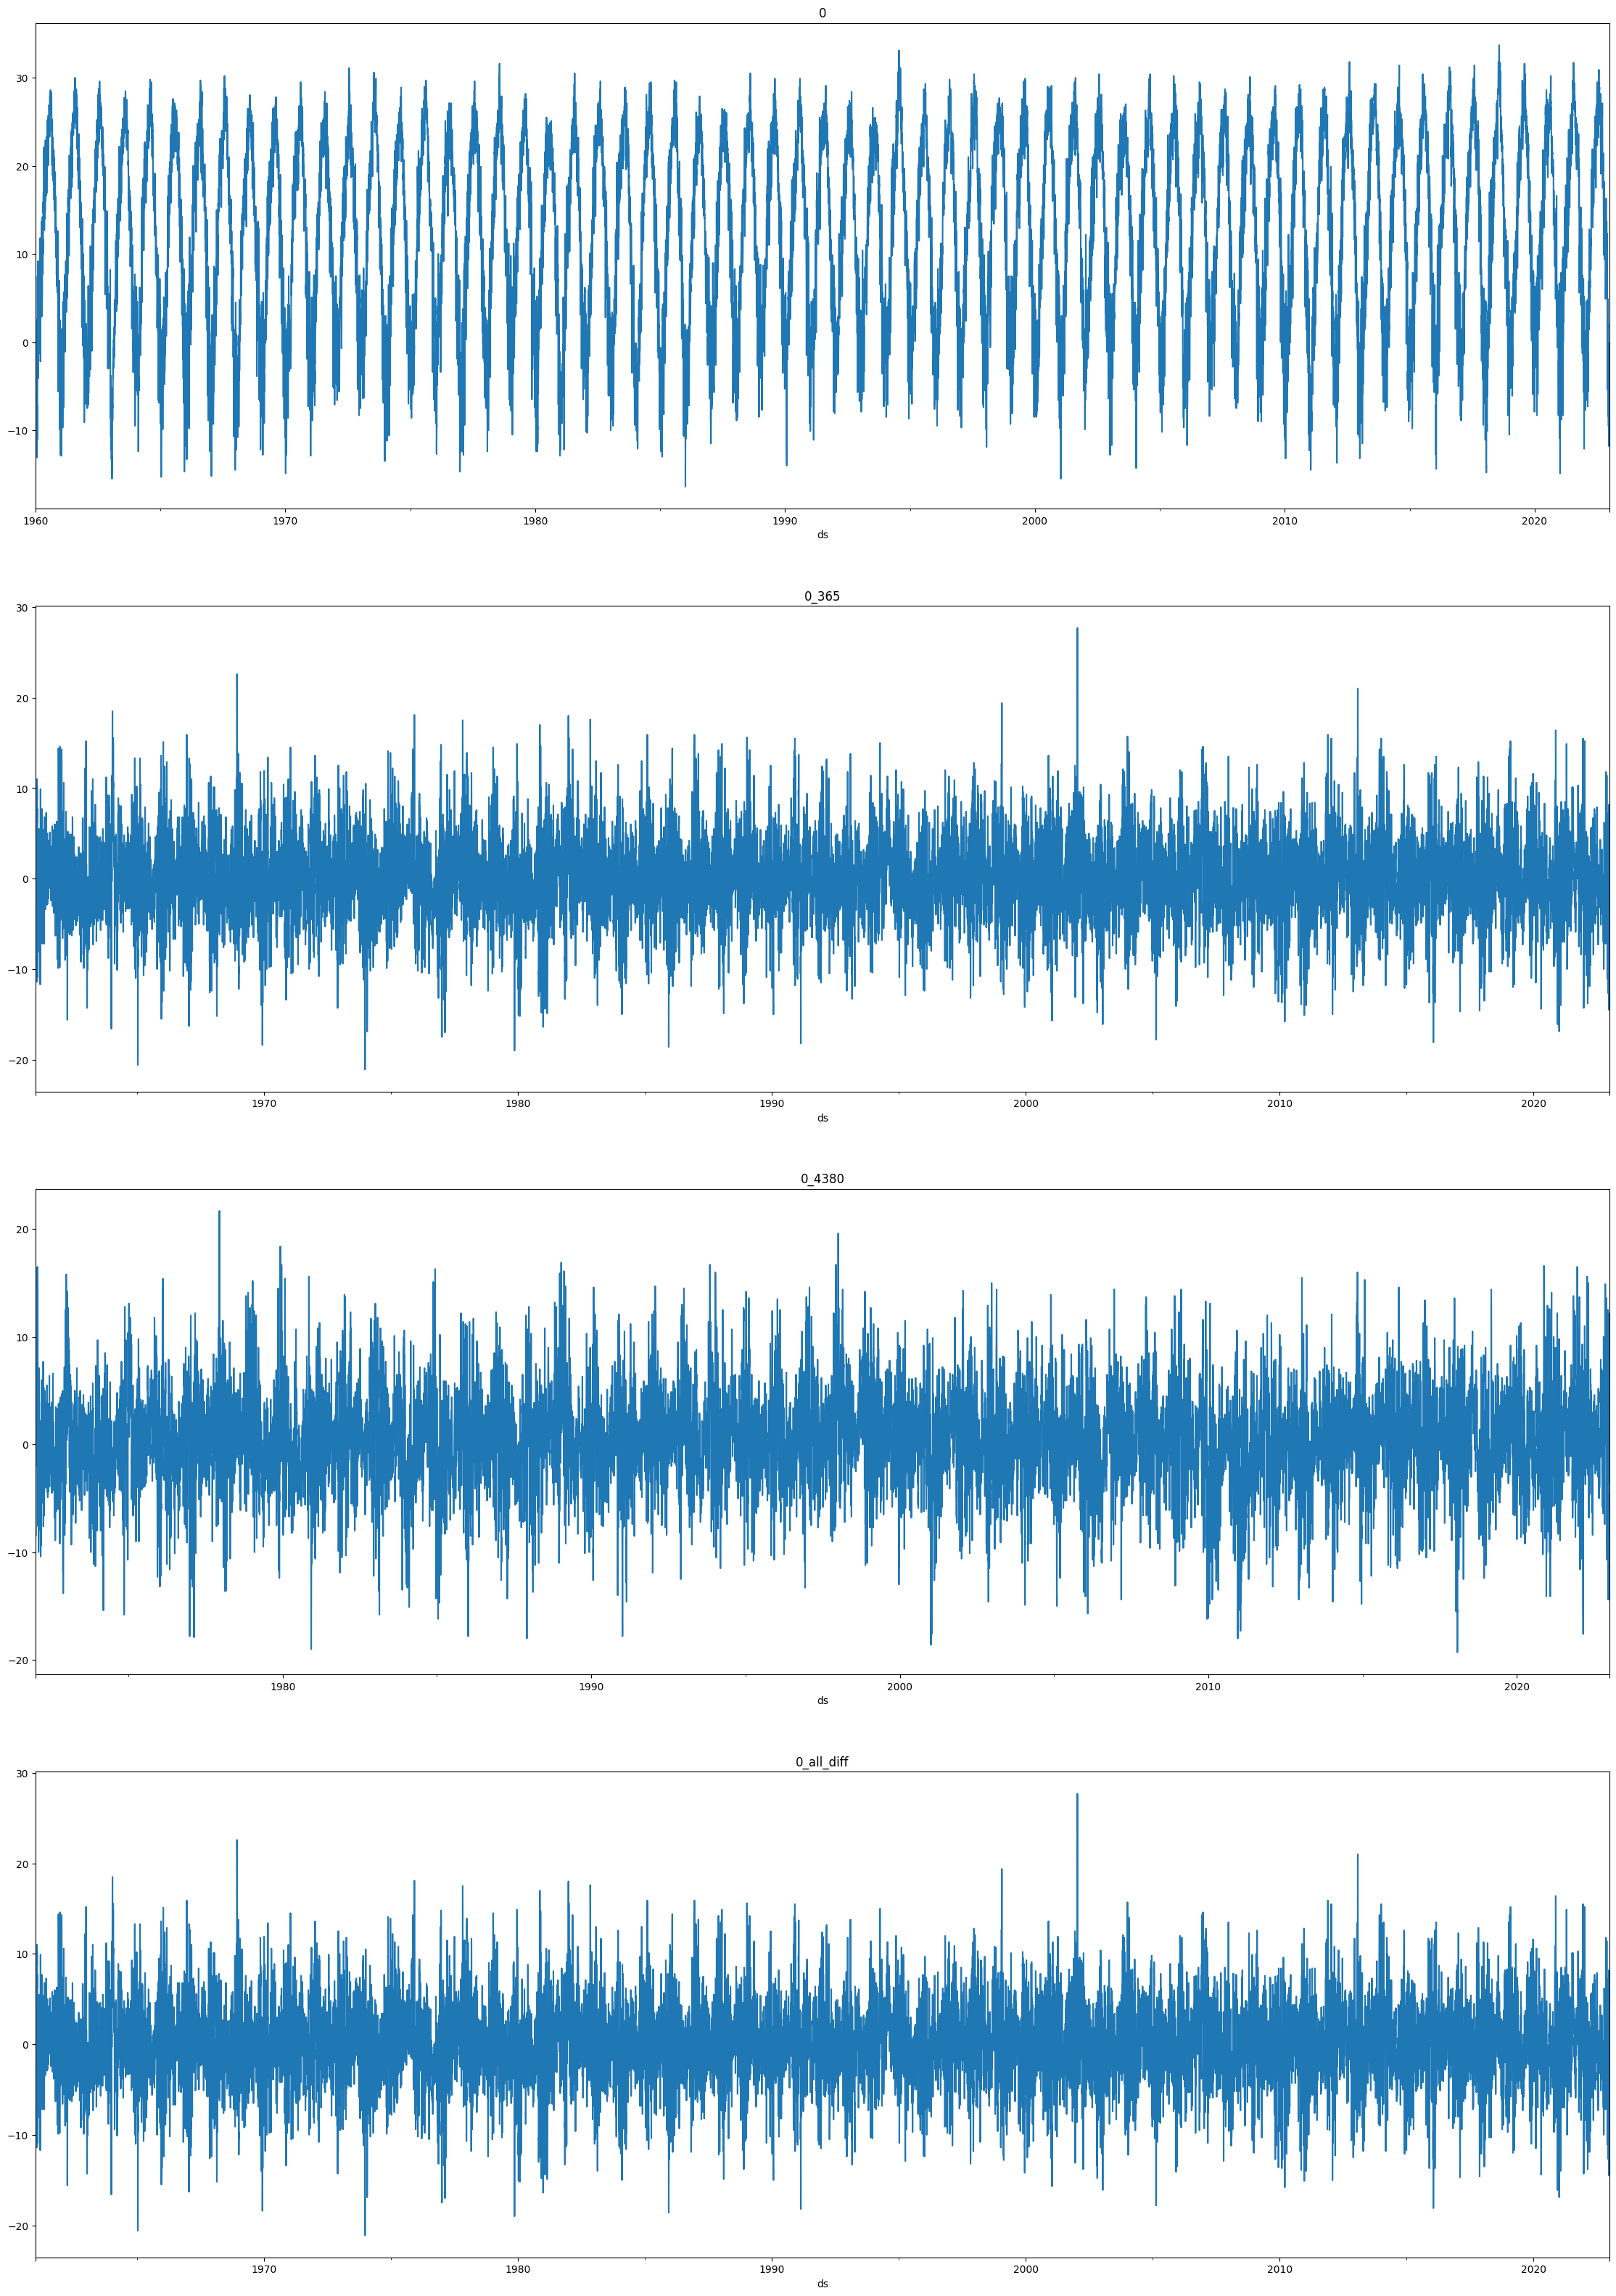

In [ ]:
plot_differences(df=train_df[['ds', 'y', 'unique_id']], differences=[365,365*12], fname='load_forecasting__differences.png')


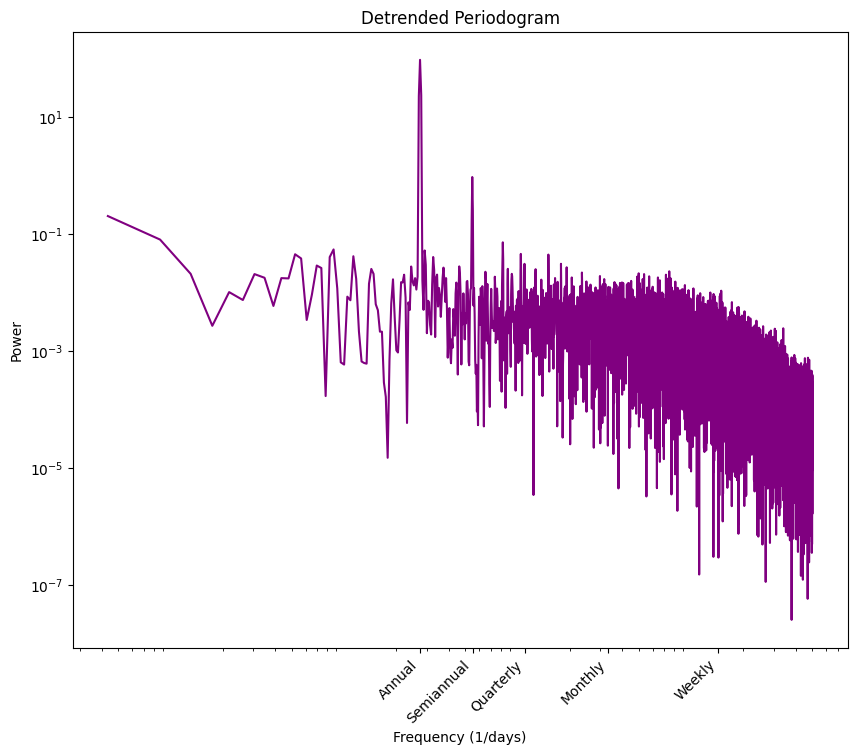

In [ ]:
def plot_periodogram(ts, ax=None):
    # Subtract the mean to detrend the time series
    ts_detrended = ts - np.mean(ts)

    # Define the sampling frequency as one day
    fs = 1

    # Use the periodogram function to get frequencies and the power spectrum
    frequencies, spectrum = periodogram(ts_detrended, fs=fs, window="hann", scaling='spectrum')

    # Exclude the zero frequency to avoid the peak at the mean
    frequencies = frequencies[1:]
    spectrum = spectrum[1:]

    if ax is None:
        fig, ax = plt.subplots()

    # Plot the periodogram
    ax.plot(frequencies, spectrum, color="purple")

    # Set the x-axis to a logarithmic scale to better visualize the data
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Set labels for the x-axis frequencies based on common time series periods
    freq_labels = [1/365, 1/182, 1/91, 1/30, 1/7]
    freq_names = ['Annual', 'Semiannual', 'Quarterly', 'Monthly', 'Weekly']
    ax.set_xticks(freq_labels)
    ax.set_xticklabels(freq_names, rotation=45, ha="right")

    # Set the axis labels and title
    ax.set_xlabel('Frequency (1/days)')
    ax.set_ylabel('Power')
    ax.set_title('Detrended Periodogram')

    plt.show()

# Assuming 'train_df' is your DataFrame and 'y' is the column with time series data
plot_periodogram(train_df['y'].values)

### Add Fourier Terms for periodicity

In [ ]:
# Generate Fourier terms for seasonality, if needed.
# The order can be adjusted based on the strength of the seasonal component in the data.
fourier_M = CalendarFourier(freq='M', order=2)  # Example order for monthly seasonality
fourier_A = CalendarFourier(freq='A-Dec', order=2)

# Create a Deterministic Process with a trend and Fourier terms for seasonality.
dp = DeterministicProcess(
    index=train_df.ds,  # Ensure this is a datetime index
    constant=True,  # Include a constant term if needed
    order=1,  # Include a trend term because the data shows a linear trend
    seasonal=False,  # Set to False if using Fourier terms for seasonality
    additional_terms=[fourier_M, fourier_A],  # Include Fourier terms for seasonality
    drop=True
)

# Generate the design matrix with in-sample predictions
X = dp.in_sample()

# Align the index of X with train_df before concatenation
X.index = train_df.index

# Concatenate the Fourier terms with the original training data
train_df_with_trend_and_fourier = pd.concat([train_df, X], axis=1)

# Now you can use this DataFrame to fit your model.


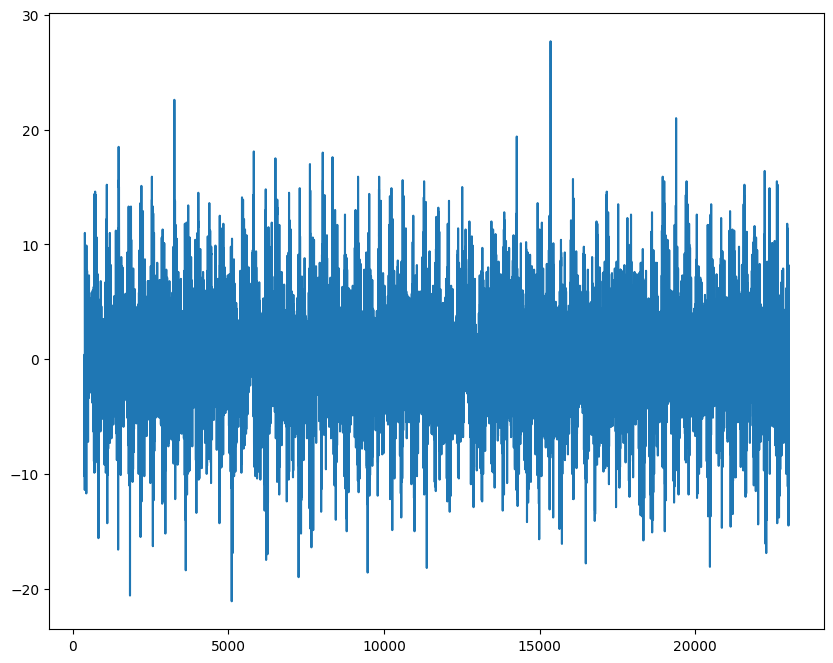

In [ ]:
plt.plot(train_df_with_trend_and_fourier.y.diff(365).dropna())


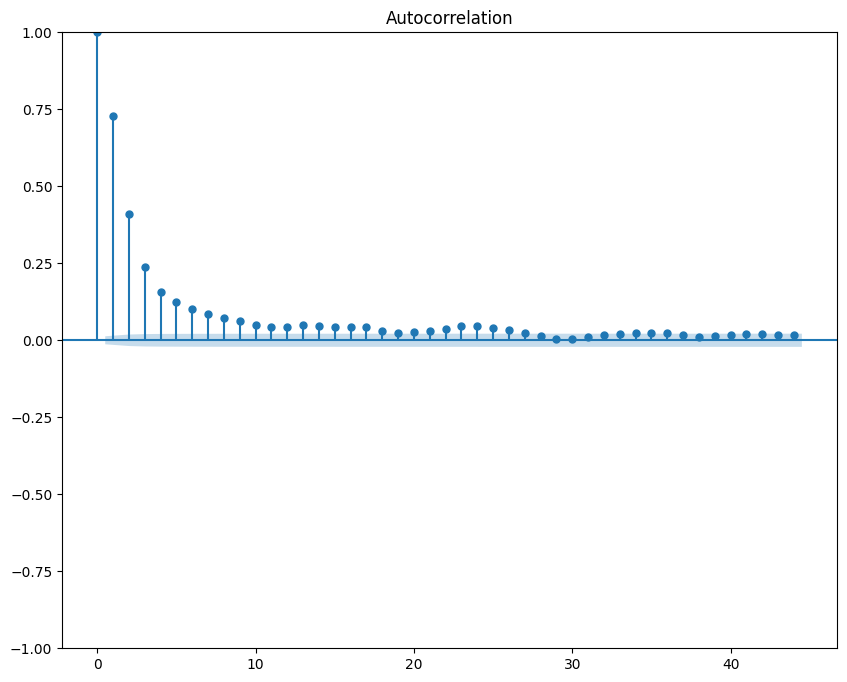

In [ ]:
plot_acf(train_df_with_trend_and_fourier.y.diff(365).dropna());


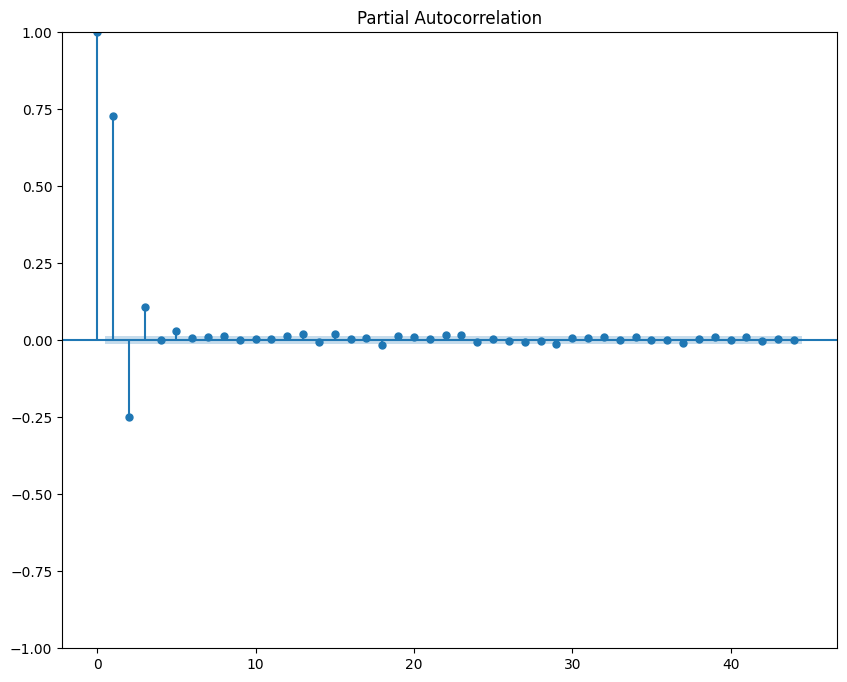

In [ ]:
plot_pacf(train_df_with_trend_and_fourier.y.diff(365).dropna());


### Try to decompose the timeseries

In [ ]:
res = MSTL(train_df_with_trend_and_fourier.y, periods=(365,12*365), iterate=3).fit()
res.plot()
plt.tight_layout()
plt.show()

KeyboardInterrupt: ignored

### Check for the PACF(AR), ACF(MA)

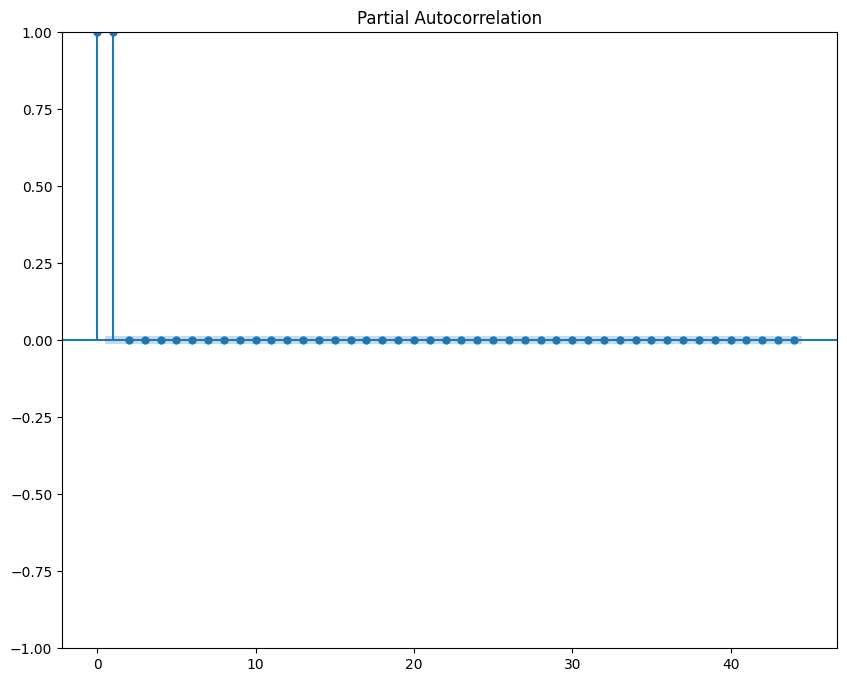

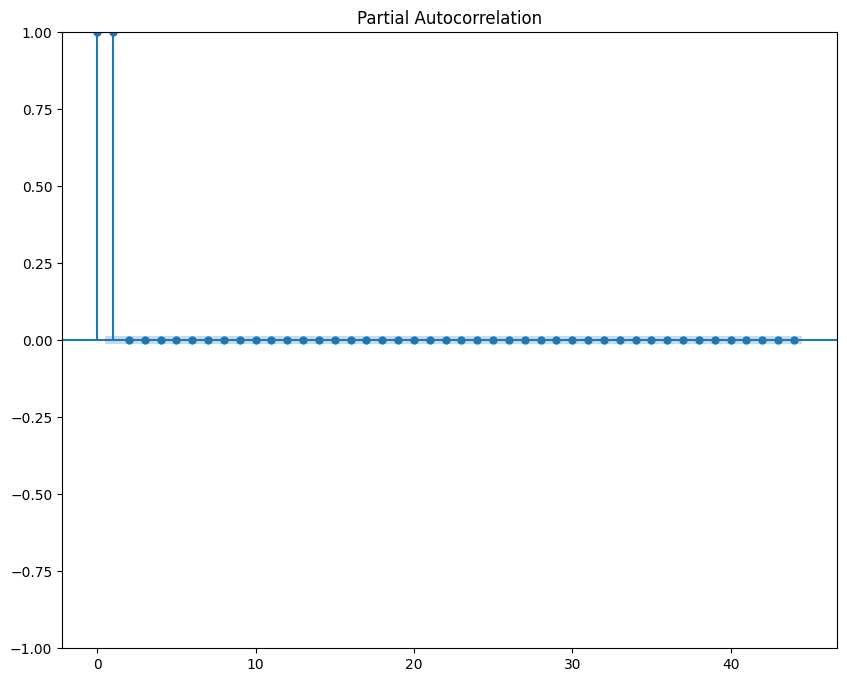

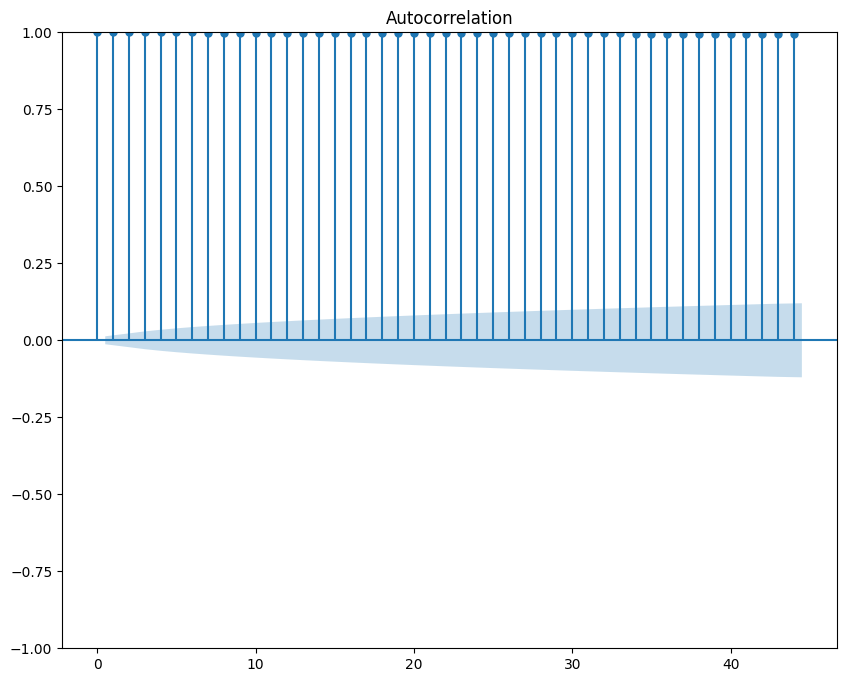

In [ ]:
display(plot_pacf(res.trend));
plot_acf(res.trend);

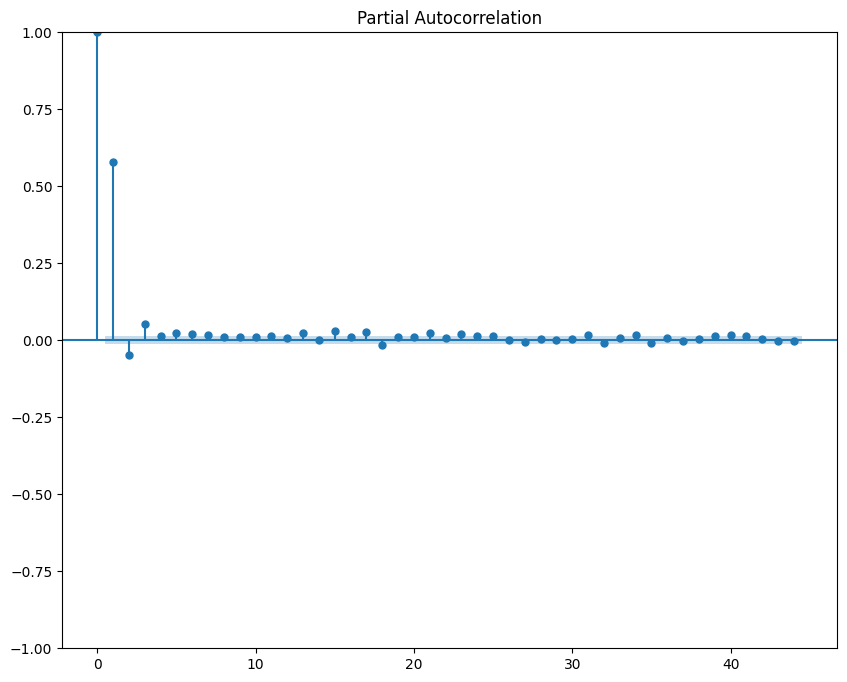

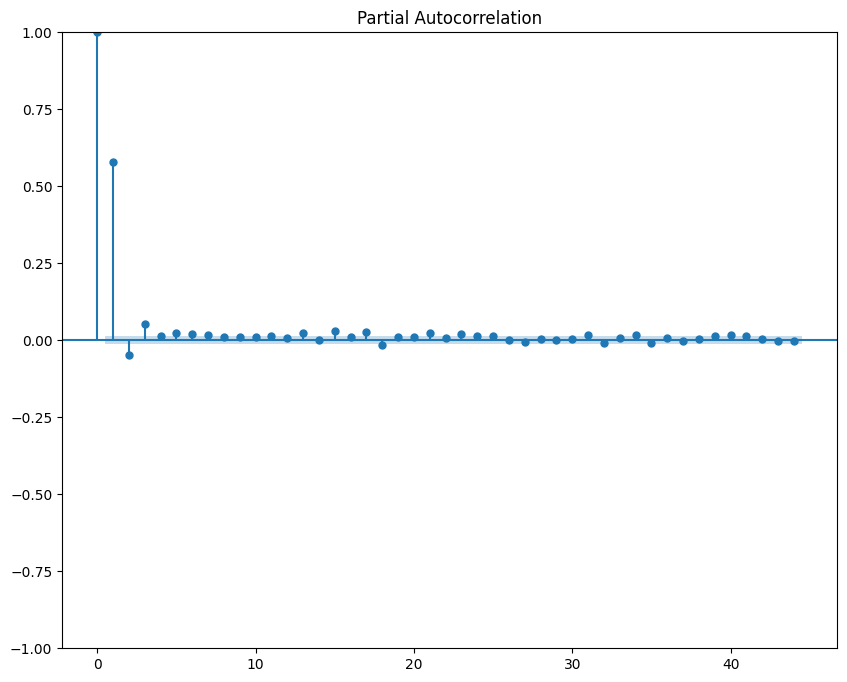

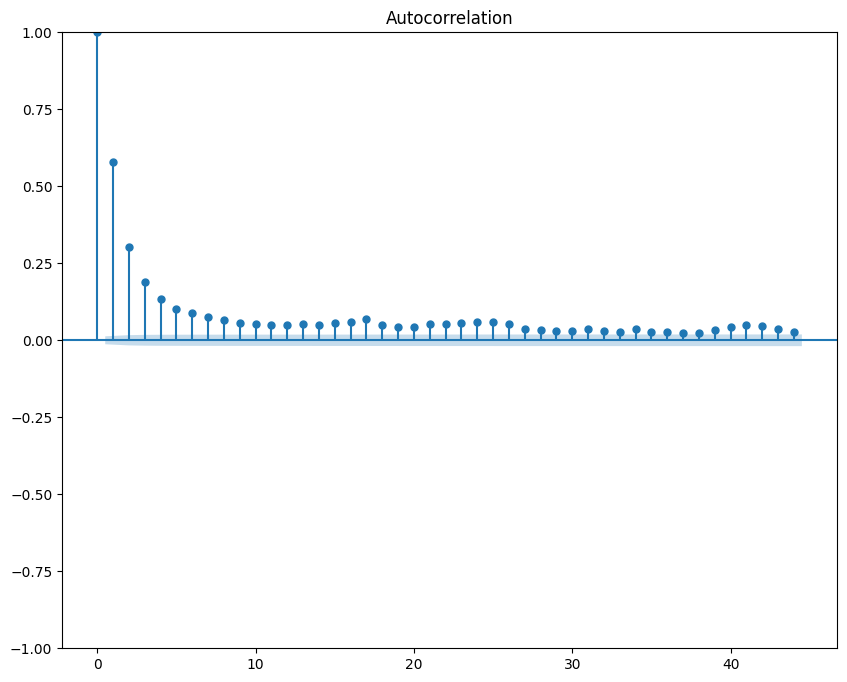

In [ ]:
display(plot_pacf(res.resid));
plot_acf(res.resid);

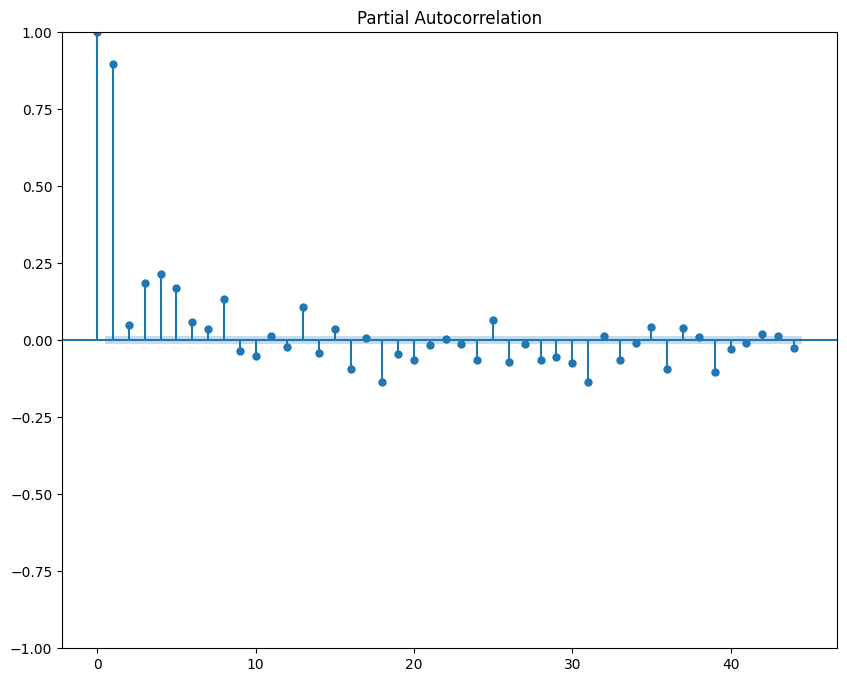

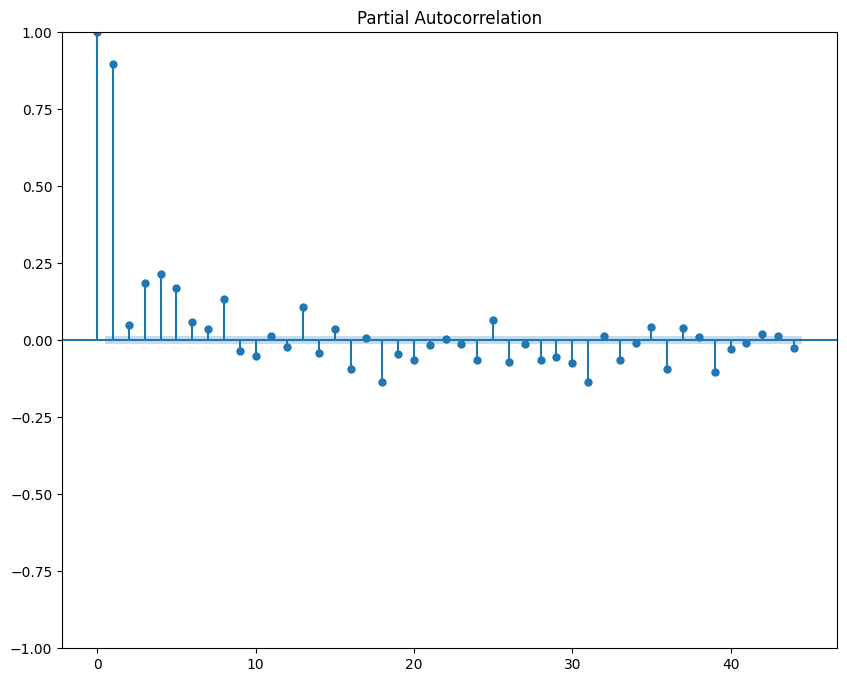

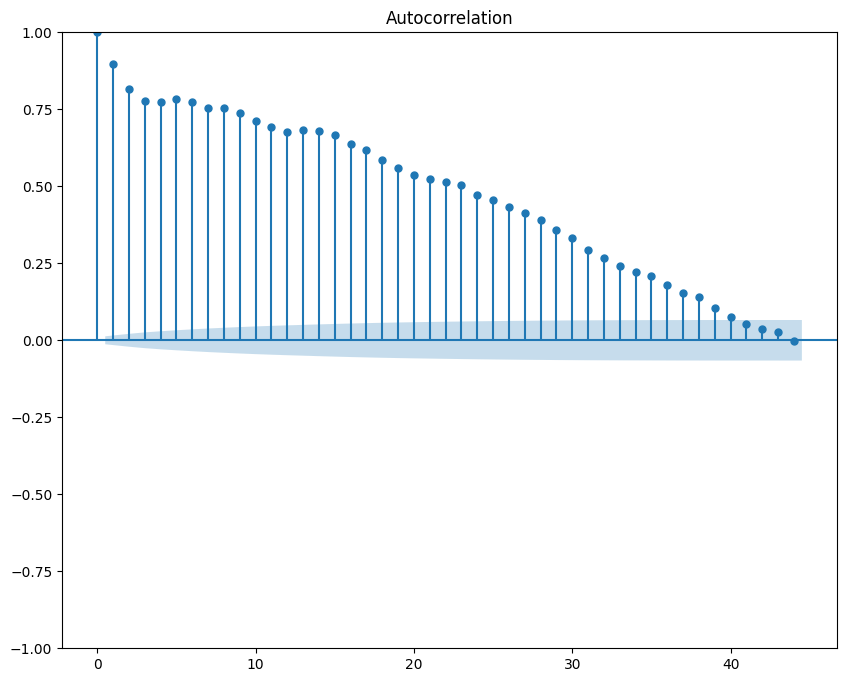

In [ ]:
display(plot_pacf(res.seasonal.seasonal_182));
plot_acf(res.seasonal.seasonal_182);

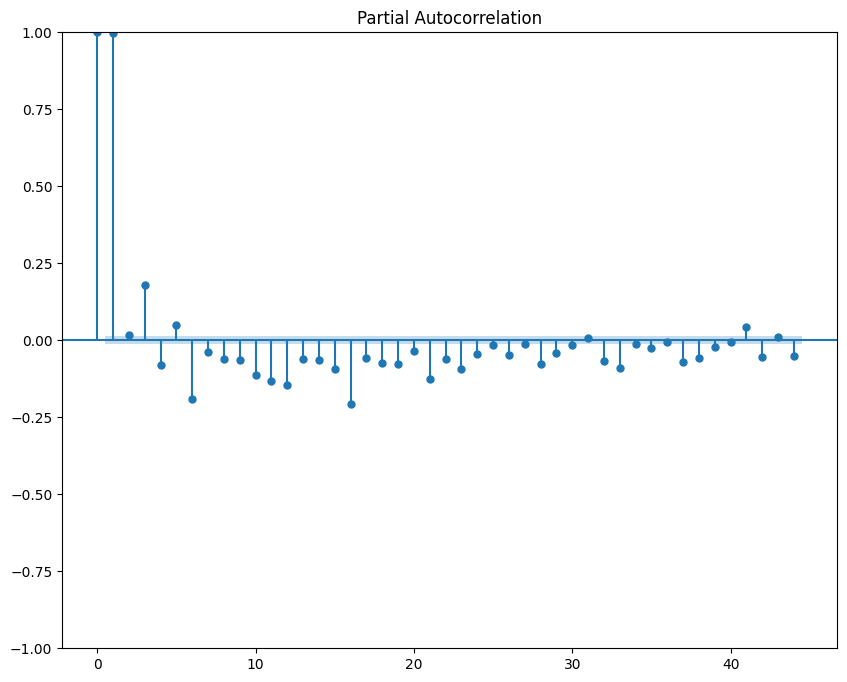

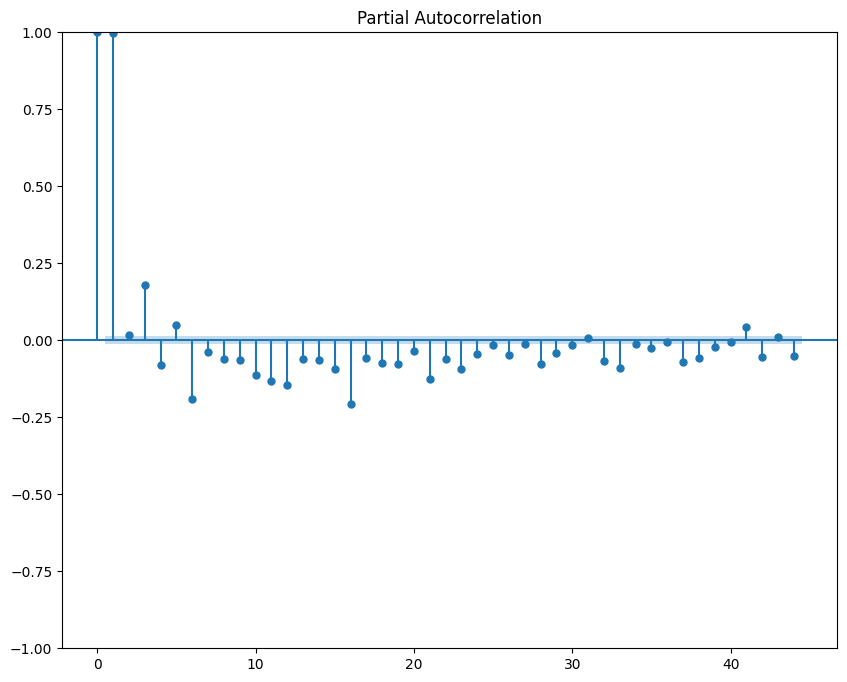

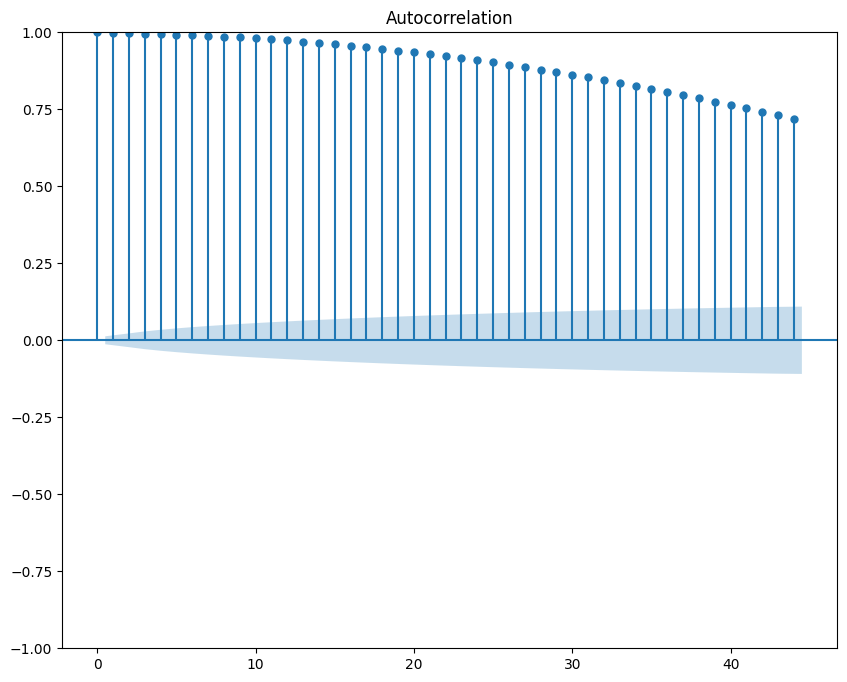

In [ ]:
display(plot_pacf(res.seasonal.seasonal_365));
plot_acf(res.seasonal.seasonal_365);

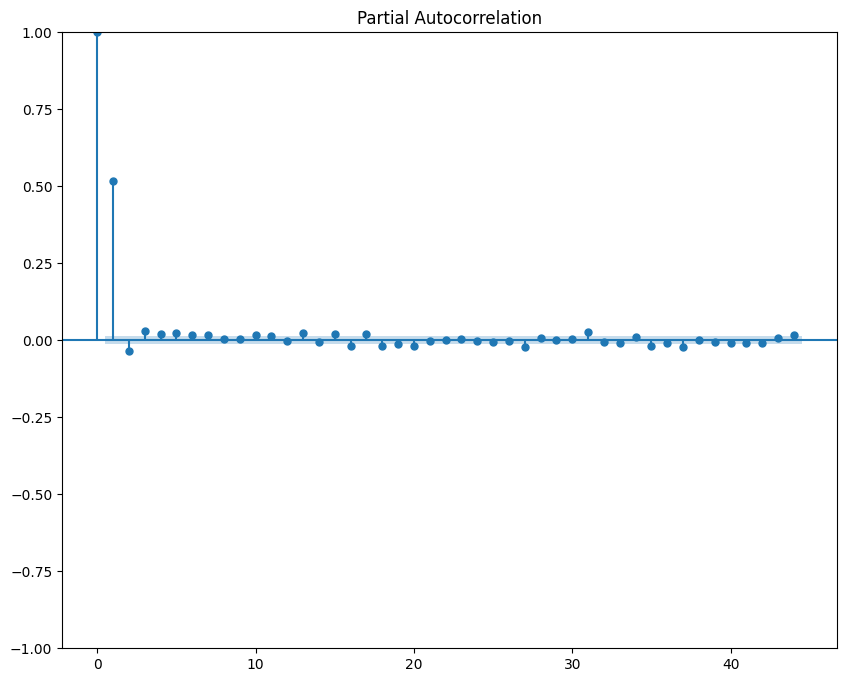

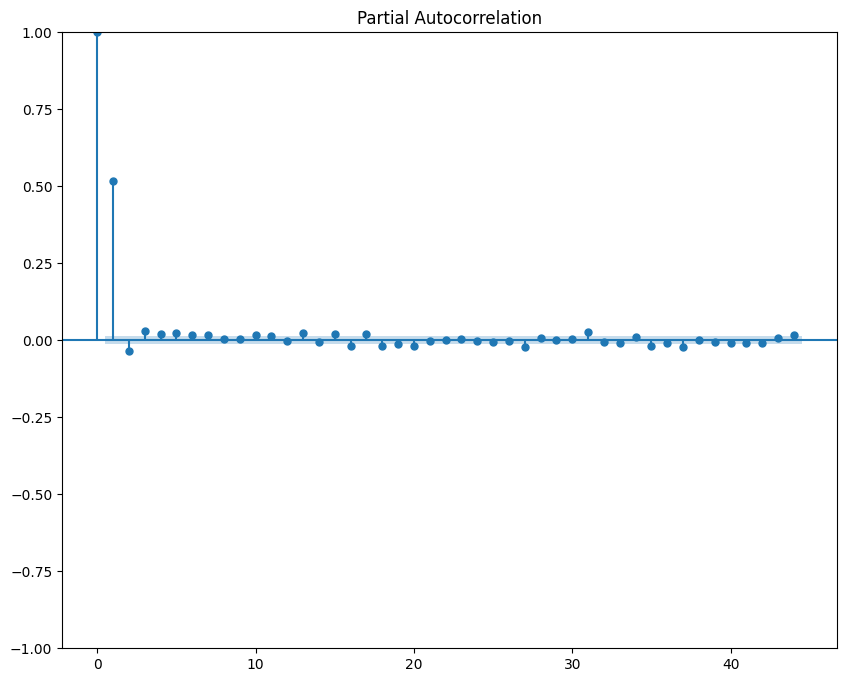

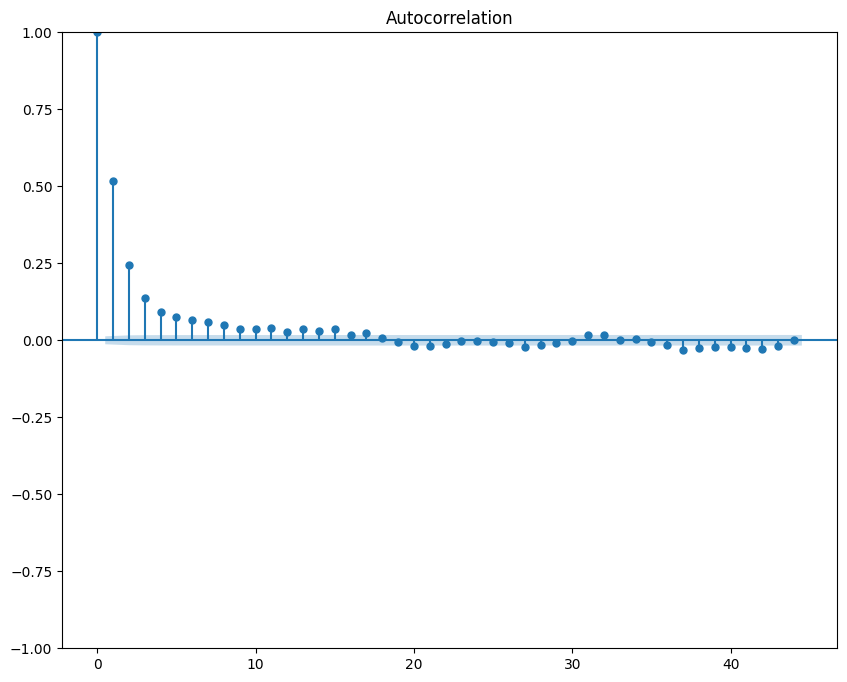

In [ ]:
display(plot_pacf(res.seasonal.seasonal_4380));
plot_acf(res.seasonal.seasonal_4380);

### df for each components

In [ ]:
train_df_with_trend_and_fourier['trend'] = res.trend
train_df_with_trend_and_fourier['365_seasonal'] = res.seasonal.seasonal_365
train_df_with_trend_and_fourier['4380_seasonal'] = res.seasonal.seasonal_4380
train_df_with_trend_and_fourier['resid'] = res.resid

### Multicolinearity test

In [ ]:
eda_df = train_df_with_trend_and_fourier.select_dtypes(include='number').drop(['unique_id','const'],axis=1)

In [ ]:
corr = eda_df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
for i in range(30):
  eda_df[i+1] = eda_df.y.shift(i).fillna(method="bfill")

In [ ]:
(eda_df).corr().style.background_gradient(cmap='coolwarm')


### GrangerCausality test

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

# Assuming `df` is a DataFrame with two stationary time series, 'X' and 'Y'
# The values are floats and not differenced.

# Check for stationarity first and difference if necessary
# df['X'] = df['X'].diff().dropna()
# df['Y'] = df['Y'].diff().dropna()

# Perform the Granger causality test
# The maximum number of lags to test for X's impact on Y is set to some number, like 4
# The test is performed at the 5% significance level by default
granger_test_result = grangercausalitytests(train_df[['y', '일조율']], maxlag=8, verbose=True)

# Interpret the output
# Null hypothesis: 'X' does not Granger-cause 'Y'
# If the p-value is less than the significance level (e.g., 0.05),
# we reject the null hypothesis and conclude 'X' Granger-causes 'Y'.


### do some granger causality to include or exclude more features

### Preprocessing columnNames for lgb

In [ ]:
train_df_with_trend_and_fourier.columns = [col.replace('(', '').replace(')', '').replace(',', '').replace('freq=M', 'freq_M') for col in train_df_with_trend_and_fourier.columns]
col_list = list(train_df_with_trend_and_fourier.columns)

In [ ]:
train_df_= train_df_with_trend_and_fourier

### decomposed dfs

In [ ]:
train_df_trend = train_df_.copy()
train_df_365_seasonal = train_df_.copy()
train_df_4380_seasonal = train_df_.copy()
train_df_resid = train_df_.copy()

In [ ]:
train_df_trend['y'] = train_df_['trend']
train_df_365_seasonal['y'] = train_df_['365_seasonal']
train_df_4380_seasonal['y'] = train_df_['4380_seasonal']
train_df_resid['y'] = train_df_['resid']

In [ ]:
train_df_trend = train_df_trend[['ds', 'y', 'unique_id']]
train_df_365_seasonal = train_df_365_seasonal[['ds', 'y', 'unique_id']]
train_df_4380_seasonal = train_df_182_seasonal[['ds', 'y', 'unique_id']]
train_df_resid = train_df_resid[['ds', 'y', 'unique_id']]

### original df

In [ ]:
train_df_mean = train_df_.copy()
train_df_mean = train_df_mean[['ds', 'y', 'unique_id']]

## Basic Setting

In [ ]:
class Naive(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X['lag1']

In [ ]:
# Metrics to be used for evaluation
metrics = [
    mae,
    rmse,
    mape,
    smape
    ]


In [ ]:
# Function to evaluate the crossvalidation
def evaluate_crossvalidation(crossvalidation_df, metrics, models):
    evaluations = []
    for c in crossvalidation_df['cutoff'].unique():
        df_cv = crossvalidation_df.query('cutoff == @c')
        evaluation = evaluate(
            df = df_cv,
            metrics=metrics,
            models=list(models.keys())
            )
        evaluations.append(evaluation)
    evaluations = pd.concat(evaluations, ignore_index=True).drop(columns='unique_id')
    evaluations = evaluations.groupby('metric').mean()
    return evaluations.style.background_gradient(cmap='RdYlGn_r', axis=1)

In [ ]:
def plot_cv(df, df_cv, uid, fname, last_n=24 * 14, models={}):
    cutoffs = df_cv.query('unique_id == @uid')['cutoff'].unique()
    fig, ax = plt.subplots(nrows=len(cutoffs), ncols=1, figsize=(14, 14), gridspec_kw=dict(hspace=0.8))
    for cutoff, axi in zip(cutoffs, ax.flat):
        max_date = df_cv.query('unique_id == @uid & cutoff == @cutoff')['ds'].max()
        df[df['ds'] < max_date].query('unique_id == @uid').tail(last_n).set_index('ds').plot(ax=axi, title=uid, y='y')
        for m in models.keys():
            df_cv.query('unique_id == @uid & cutoff == @cutoff').set_index('ds').plot(ax=axi, title=uid, y=m)

    plt.show();

In [ ]:
levels = [90, 95] # Levels for prediction intervals


## Diagnostic Functions

In [ ]:
def fit_diagnostic(series):
    sw_result = stats.shapiro(series)
    ad_result = normal_ad(np.array(series), axis=0)
    dag_result = stats.normaltest(series, axis=0, nan_policy='propagate')
    return sw_result, ad_result, dag_result


In [ ]:
def normal_test(fcst, result_series):
    result=fcst.forecast_fitted_values()
    fig, axs = plt.subplots(nrows=2, ncols=2)

    sw_result, ad_result, dag_result = fit_diagnostic(result_series)

    # plot[1,1]
    result_series.plot(ax=axs[0,0])
    axs[0,0].set_title("Residuals model");

    # plot
    axs[0,1].hist(result_series, density=True,bins=50, alpha=0.5 )
    axs[0,1].set_title("Density plot - Residual");

    # plot
    stats.probplot(result_series, dist="norm", plot=axs[1,0])
    axs[1,0].set_title('Plot Q-Q')
    axs[1,0].annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
                bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

    axs[1,0].annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
                bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

    axs[1,0].annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
                bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
    # plot
    plot_acf(res_365s["lgb_1"],  lags=35, ax=axs[1,1],color="fuchsia")
    axs[1,1].set_title("Autocorrelation");


    plt.savefig("../../figs/prediction_intervals_in_forecasting_models__plot_residual_model.png", bbox_inches='tight')
    plt.close();

# Statistical model MSTL IMAPA

In [ ]:
st_models = [MSTL(season_length=[365,12*365], # seasonalities of the time series
trend_forecaster=AutoARIMA(prediction_intervals=ConformalIntervals(n_windows=3, h=358)))]
sf = StatsForecast(df=train_df_mean,
                   models=st_models,
                   freq='D',
                   n_jobs=-1)

crossvalidation_df_sf = sf.cross_validation(
    df=train_df_mean,
    h=30,
    n_windows=12,
    refit=False,
)


In [ ]:
st_models = {'MSTL': MSTL(season_length=[365,12*365], # seasonalities of the time series
trend_forecaster=AutoARIMA(prediction_intervals=ConformalIntervals(n_windows=3, h=358))),}

In [ ]:
crossvalidation_df_sf

ds     cutoff     y       MSTL
unique_id                                       
0         2022-11-21 2022-11-20  11.8  11.212355
0         2022-11-22 2022-11-20  10.7   6.026212
0         2022-11-23 2022-11-20  10.8   0.410982
0         2022-11-24 2022-11-20   9.4   2.563348
0         2022-11-25 2022-11-20  12.3   3.899763
...              ...        ...   ...        ...
0         2022-12-27 2022-12-01  -2.6  -0.767512
0         2022-12-28 2022-12-01  -3.3   2.511826
0         2022-12-29 2022-12-01  -2.9   3.147555
0         2022-12-30 2022-12-01  -1.8  -6.333234
0         2022-12-31 2022-12-01  -1.2  -4.096209

[360 rows x 4 columns]

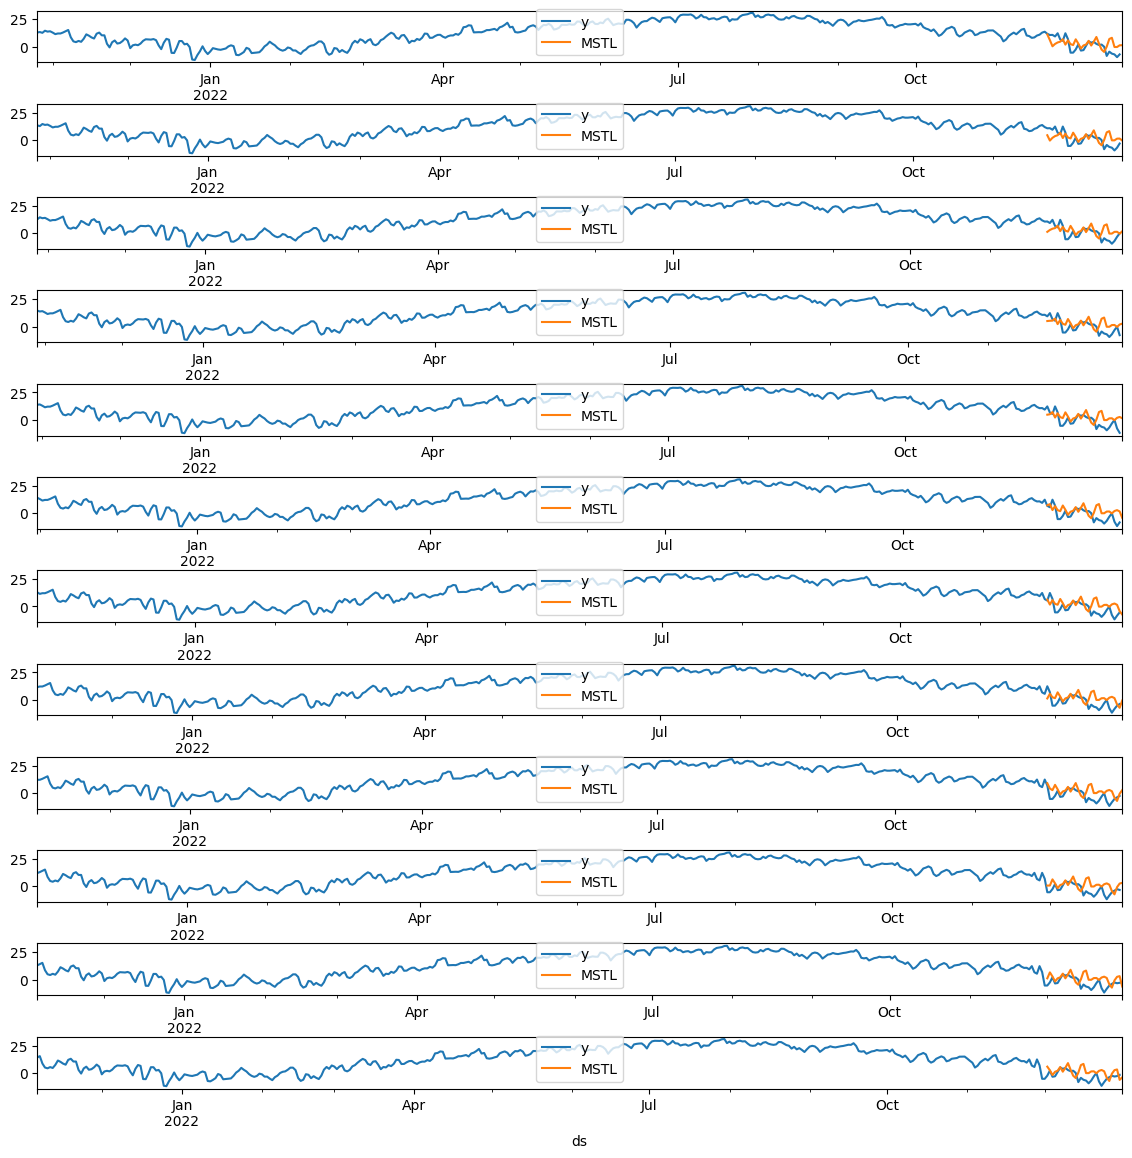

In [ ]:
plot_cv(train_df_mean, crossvalidation_df_sf, 0, 'Temp mean', models=st_models, last_n=30 * 14)

In [ ]:
sf.fit()
st_pred = sf.forecast(358, fitted=True)

# ML apporach

## ML Ensemble Decomposed targets

In [ ]:
lgb_params_1 = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.00001, 0.00005, 0.005, 0.01, 0.1],
    'num_leaves': [31, 61, 81],
}

lgb_params_2 = {
    'n_estimators': [2000],
    'learning_rate': [0.00001, 0.00005],
    'num_leaves': [31, 61],
    'lambda_l1': [0.1, 1.0],  # L1 regularization
    'lambda_l2': [0.1, 1.0],  # L2 regularization
    'min_gain_to_split': [0.1, 1.0],  # Minimum loss reduction required to make a further partition
    'max_depth': [15, 20],  # Limiting tree depth
    'min_data_in_leaf': [20, 50],  # Minimum number of data points in a leaf
}

lgb_params_3 = {
    'n_estimators': [200,300],
    'learning_rate': [0.001, 0.01],
    'num_leaves': [31, 61],
}

lgb_params_4 = {
    'n_estimators': [200,300],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 61],
}

rf_params = {    'bootstrap': [True],
    'max_depth': [70, 130],
    'max_features': [3, 6],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [4, 8],
    'n_estimators': [1000, 500]
}
adb_params = {
    'n_estimators' : [100,200],
    'learning_rate': [0.01, 0.1],
}


# Regularized linear model - Ridge or Lasso
# Using make_pipeline to ensure features are scaled appropriately for the linear model
# linear_model = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
# Define your models, possibly with hyperparameter tuning via GridSearchCV
naive = Naive()
lasso = Lasso(random_state=0)
lin_reg = LinearRegression()
ridge = Ridge(random_state=0)
mlp = MLPRegressor(random_state=0)
adb = AdaBoostRegressor(random_state=0)
sgdr = make_pipeline(StandardScaler(),
                    SGDRegressor(loss='squared_error', penalty='l2', max_iter=2000, tol=5e-5, random_state=0))
lgb_model_1 = GridSearchCV(lgb.LGBMRegressor(verbosity=-1, objective='fair', random_state=0), lgb_params_1, cv=3)
lgb_model_2 = GridSearchCV(lgb.LGBMRegressor(verbosity=-1, random_state=0, objective='fair'), lgb_params_2, cv=3)
lgb_model_3 = GridSearchCV(lgb.LGBMRegressor(verbosity=-1,  random_state=0, boosting_type='dart'), lgb_params_3, cv=3)
lgb_model_4 = GridSearchCV(lgb.LGBMRegressor(verbosity=-1,  random_state=0, boosting_type='dart'), lgb_params_4, cv=3)
rf_model = GridSearchCV(RandomForestRegressor(random_state=0), rf_params, cv=3)

# Update the stacking ensemble to include the linear model
stacked_ensemble = StackingRegressor(
    estimators=[
        ('lgb_1', lgb_model_1),
        ('sgdr', sgdr),

    ],
    final_estimator=GridSearchCV(RandomForestRegressor(random_state=0), rf_params, cv=3)
)


models_trend = {
    'lgb_1':lgb_model_1,
    'lgb_2': lgb_model_2,
    'naive': naive,
    'lasso': lasso,
    'adb': adb,
    'sgdr': sgdr,
}

models_90s = {
    'lgb_1':lgb_model_1,
    'lgb_2': lgb_model_2,
    'naive': naive,
    'lasso': lasso,
    'adb': adb,
    'sgdr': sgdr,
}

models_182s = {
    'lgb_1':lgb_model_1,
    'lgb_2': lgb_model_2,
    'naive': naive,
    'lasso': lasso,
    'adb': adb,
    'sgdr': sgdr,
}

models_365s = {
    'lgb_1':lgb_model_1,
    'lgb_2': lgb_model_2,
    'naive': naive,
    'lasso': lasso,
    'adb': adb,
    'sgdr': sgdr,
}

models_4380s = {
    'lgb_1':lgb_model_1,
    'lgb_2': lgb_model_2,
    'naive': naive,
    'lasso': lasso,
    'adb': adb,
    'sgdr': sgdr,
}

# Include them in the models list
models_resid = {
    'lgb_1':lgb_model_1,
    'lgb_2': lgb_model_2,
    'naive': naive,
    'lasso': lasso,
    'adb': adb,
    'sgdr': sgdr,
}



# Define your MLForecast instance
fcst_trend = MLForecast(
    models=models_trend,
    freq='D',  # daily frequency
    # target_transforms=[Differences([365])], # for seasonality
    lags=[1,3,30,120,365],  # lags you have chosen 1,3 from pacf acf
    date_features=["year", "month", "day"]
)

fcst_365s = MLForecast(
    models=models_365s,
    freq='D',  # daily frequency
    # target_transforms=[Differences([365])], # for seasonality
    lags=[1,3,30,120,365], # lags you have chosen 1,3 from pacf acf
    date_features=["year", "month", "day"]
)

fcst_4380s = MLForecast(
    models=models_4380s,
    freq='D',  # daily frequency
    # target_transforms=[Differences([365])], # for seasonality
    lags=[1,3,30,120,365], # lags you have chosen 1,3 from pacf acf
    date_features=["year", "month", "day"]
)

fcst_resid = MLForecast(
    models=models_resid,
    freq='D',  # daily frequency
    # target_transforms=[Differences([365])], # for seasonality
    lags=[1,3,30,120,365],  # lags you have chosen 1,3 from pacf acf
    # lags=[1],
    date_features=["year", "month", "day"]
)

crossvalidation_df_trend = fcst_trend.cross_validation(
    df=train_df_trend,
    h=30,
    n_windows=12,
    refit=False,
)

crossvalidation_df_365s = fcst_365s.cross_validation(
    df=train_df_365_seasonal,
    h=30,
    n_windows=12,
    refit=False,
)

crossvalidation_df_4380s = fcst_4380s.cross_validation(
    df=train_df_4380_seasonal,
    h=30,
    n_windows=12,
    refit=False,
)

crossvalidation_df_resid = fcst_resid.cross_validation(
    df=train_df_resid,
    h=30,
    n_windows=12,
    refit=False,
)

plot_cv(train_df_trend, crossvalidation_df_trend, 0, 'Temp min', models=models_trend, last_n=30 * 14)
plot_cv(train_df_365_seasonal, crossvalidation_df_365s, 0, 'Temp min', models=models_365s, last_n=30 * 14)
plot_cv(train_df_4380_seasonal, crossvalidation_df_4380s, 0, 'Temp min', models=models_4380s, last_n=30 * 14)
plot_cv(train_df_resid, crossvalidation_df_resid, 0, 'Temp min', models=models_resid, last_n=30 * 14)

KeyboardInterrupt: ignored

In [ ]:
display(evaluate_crossvalidation(crossvalidation_df_trend, metrics, models_trend))
display(evaluate_crossvalidation(crossvalidation_df_365s, metrics, models_365s))
display(evaluate_crossvalidation(crossvalidation_df_4380s, metrics, models_4380s))
display(evaluate_crossvalidation(crossvalidation_df_resid, metrics, models_resid))

## ML Ensemble mean targets

In [ ]:
lgb_params_1 = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.00001, 0.00005, 0.005, 0.01, 0.1],
    'num_leaves': [31, 61, 81],
    # 'device_type': 'gpu',
}

# lgb_params_2 = {
#     'n_estimators': [1200,1400],
#     'learning_rate': [0.00001, 0.00005, 0.005, 0.01, 0.1],
#     'num_leaves': [31, 61],
# }

lgb_params_2 = {
    'n_estimators': [2000],
    'learning_rate': [0.00001, 0.00005],
    'num_leaves': [31, 61],
    'lambda_l1': [0.1, 1.0],  # L1 regularization
    'lambda_l2': [0.1, 1.0],  # L2 regularization
    'min_gain_to_split': [0.1, 1.0],  # Minimum loss reduction required to make a further partition
    'max_depth': [15, 20],  # Limiting tree depth
    'min_data_in_leaf': [20, 50],  # Minimum number of data points in a leaf
}

# lgb_params_1 = {
#     'n_estimators': [100,200],
#     'learning_rate': [0.005, 0.01],
#     'num_leaves': [31, 61],
# }


rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 40],
    'min_samples_leaf' : [50,60], # this smoothe
}

# rf_params = {    'bootstrap': [True],
#     'max_depth': [70, 130],
#     'max_features': [3, 6],
#     'min_samples_leaf': [2, 3],
#     'min_samples_split': [4, 8],
#     'n_estimators': [1000, 500]
# }
adb_params = {
    'n_estimators' : [100,200],
    'learning_rate': [0.01, 0.1],
}

hb_params = {
    'epsilon': [1, 1.5],
    'max_iter': [300,400],
    'alpha': [0.0001, 0.001]
}

TS_params = {
    'max_iter': [100, 200]
}


# Regularized linear model - Ridge or Lasso
# Using make_pipeline to ensure features are scaled appropriately for the linear model
# linear_model = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
# Define your models, possibly with hyperparameter tuning via GridSearchCV
naive = Naive()
lasso = Lasso(random_state=0)
lin_reg = LinearRegression()
ridge = Ridge(random_state=0)
# knn = KNeighborsRegressor()
mlp = MLPRegressor(random_state=0)
adb = AdaBoostRegressor(random_state=0)
hbr = GridSearchCV(HuberRegressor(), hb_params, cv=3) # memory crashed
gpr = GaussianProcessRegressor(random_state=0)
tsr = GridSearchCV(TheilSenRegressor(random_state=0), TS_params, cv=3)
sgdr = make_pipeline(StandardScaler(),
                    SGDRegressor(loss='squared_error', penalty='l2', max_iter=2000, tol=5e-5, random_state=0))
lgb_model_1 = GridSearchCV(lgb.LGBMRegressor(verbosity=-1, objective='fair', random_state=0), lgb_params_1, cv=3)
# lgb_model_C = RegressorChain(base_estimator=lgb.LGBMRegressor(verbosity=-1, objective='fair', random_state=0, n_estimators=200, learning_rate=0.005, num_leaves=31))
lgb_model_2 = GridSearchCV(lgb.LGBMRegressor(verbosity=-1, objective='fair', random_state=0), lgb_params_2, cv=3)
# xgb_model = GridSearchCV(xgb.XGBRegressor(objective='reg:absoluteerror', random_state=0), xgb_params, cv=3)
rf_model = GridSearchCV(RandomForestRegressor(random_state=0), rf_params, cv=3)
cb = CatBoostRegressor(logging_level='Silent', random_state=0)


# Update the stacking ensemble to include the linear model
stacked_ensemble = StackingRegressor(
    estimators=[
        ('lgb_1', lgb_model_1),
        ('sgdr', sgdr),
        ('cb', cb),
        # ('adb', adb),
        # ('hbr', hbr),
        # ('gpr', gpr),
        ('tsr', tsr),

        # ('linear', linear_model)  # Add the linear model
    ],
    final_estimator=GridSearchCV(RandomForestRegressor(random_state=0), rf_params, cv=3)
    # final_estimator=GridSearchCV(AdaBoostRegressor(random_state=0), adb_params, cv=3)
)


models_mean = {
    'lgb_1':lgb_model_1,
    # 'lgb_ch': lgb_model_C,
    # 'lgb_2':lgb_model_2,
    'naive': naive,
    'lasso': lasso,
    'adb': adb,
    'sgdr': sgdr,
    # 'hbr': hbr,
    # 'cb': cb,
    # 'gpr': gpr,
    # 'tsr': tsr,
    # 'qr': qr
    # 'lgb_2':lgb_model_2,
    # 'lgb_3':lgb_model_3,
    # 'lgb_4':lgb_model_4,
    # 'se': stacked_ensemble,
}


# Define your MLForecast instance
fcst_mean = MLForecast(
    models=models_mean,
    freq='D',  # daily frequency
    # target_transforms=[Differences([120])], # for seasonality
    lags=[1,3,30,120,365],  # lags you have chosen 1,3 from pacf acf
    # lag_transforms={1: [expanding_mean],3: [(rolling_mean, 7)] },
    date_features=["year", "month", "day"]
)

# Define your MLForecast instance
fcst_mean_diff = MLForecast(
    models=models_mean,
    freq='D',  # daily frequency
    target_transforms=[Differences([365])], # for seasonality
    lags=[1,3,30,120,365],  # lags you have chosen 1,3 from pacf acf
    # lag_transforms={1: [expanding_mean],3: [(rolling_mean, 7)] },
    date_features=["year", "month", "day"]
)


crossvalidation_df_mean = fcst_mean.cross_validation(
    df=train_df_mean,
    h=30,
    n_windows=12,
    refit=False,
)

crossvalidation_df_mean_diff = fcst_mean_diff.cross_validation(
    df=train_df_mean,
    h=30,
    n_windows=12,
    refit=False,
)

plot_cv(train_df_mean, crossvalidation_df_mean, 0, 'Temp mean', models=models_mean, last_n=30 * 14)
plot_cv(train_df_mean, crossvalidation_df_mean_diff, 0, 'Temp mean', models=models_mean, last_n=30 * 14)

IndexError: ignored

In [ ]:
display(evaluate_crossvalidation(crossvalidation_df_mean, metrics, models_mean))
display(evaluate_crossvalidation(crossvalidation_df_mean_diff, metrics, models_mean))

## ML Forecast

In [ ]:
# Assuming 'train_df_' is your training DataFrame

fcst_trend.fit(df=train_df_trend, fitted=True, prediction_intervals=PredictionIntervals(n_windows=60, h=358, method="conformal_distribution")) # df_length / n_windows => data chuncks
fcst_365s.fit(df=train_df_365_seasonal,fitted=True,  prediction_intervals=PredictionIntervals(n_windows=60, h=358, method="conformal_distribution"))
fcst_4380s.fit(df=train_df_4380_seasonal, fitted=True, prediction_intervals=PredictionIntervals(n_windows=60, h=358, method="conformal_distribution"))
fcst_resid.fit(df=train_df_resid, fitted=True, prediction_intervals=PredictionIntervals(n_windows=60, h=358, method="conformal_distribution"))

MLForecast(models=[lgb_1, lgb_2, naive, lasso, adb, sgdr], freq=D, lag_features=['lag1', 'lag3', 'lag30', 'lag120', 'lag365'], date_features=['year', 'month', 'day'], num_threads=1)

In [ ]:
res_t = fcst_trend.forecast_fitted_values()
res_365s = fcst_365s.forecast_fitted_values()
res_4380s = fcst_4380s.forecast_fitted_values()
res_resid = fcst_resid.forecast_fitted_values()

In [ ]:
fcst_mean.fit(df=train_df_mean, fitted=True, prediction_intervals=PredictionIntervals(n_windows=60, h=358, method="conformal_distribution"))
fcst_mean_diff.fit(df=train_df_mean, fitted=True, prediction_intervals=PredictionIntervals(n_windows=60, h=358, method="conformal_distribution"))

MLForecast(models=[lgb_1, lgb_2, naive, lasso, adb, sgdr], freq=D, lag_features=['lag1', 'lag3', 'lag30', 'lag120', 'lag365'], date_features=['year', 'month', 'day'], num_threads=1)

In [ ]:
res_mean = fcst_mean.forecast_fitted_values()
res_mean_diff = fcst_mean_diff.forecast_fitted_values()

In [ ]:
predictions_mean = fcst_mean.predict(358, level=levels)
predictions_mean_diff = fcst_mean_diff.predict(358, level=levels)

In [ ]:
predictions_trend = fcst_trend.predict(358, level=levels)
# predictions_90s = fcst_90s.predict(358, level=levels)
# predictions_182s = fcst_182s.predict(358, level=levels)
predictions_365s = fcst_365s.predict(358, level=levels)
predictions_4380s = fcst_4380s.predict(358, level=levels)
predictions_resid = fcst_resid.predict(358, level=levels)

# predictions_mean = fcst_mean.predict(358, level=levels)

In [ ]:
normal_test(fcst_trend,res_t.lgb_1)

# DL Models

## TimeGPT

In [ ]:
timegpt = TimeGPT(
    # defaults to os.environ.get("TIMEGPT_TOKEN")
    token = ''
)

In [ ]:
fcst_df = timegpt.forecast(train_df_mean, h=358, level=[90, 95], model='timegpt-1-long-horizon', target_col='y', finetune_steps=400)


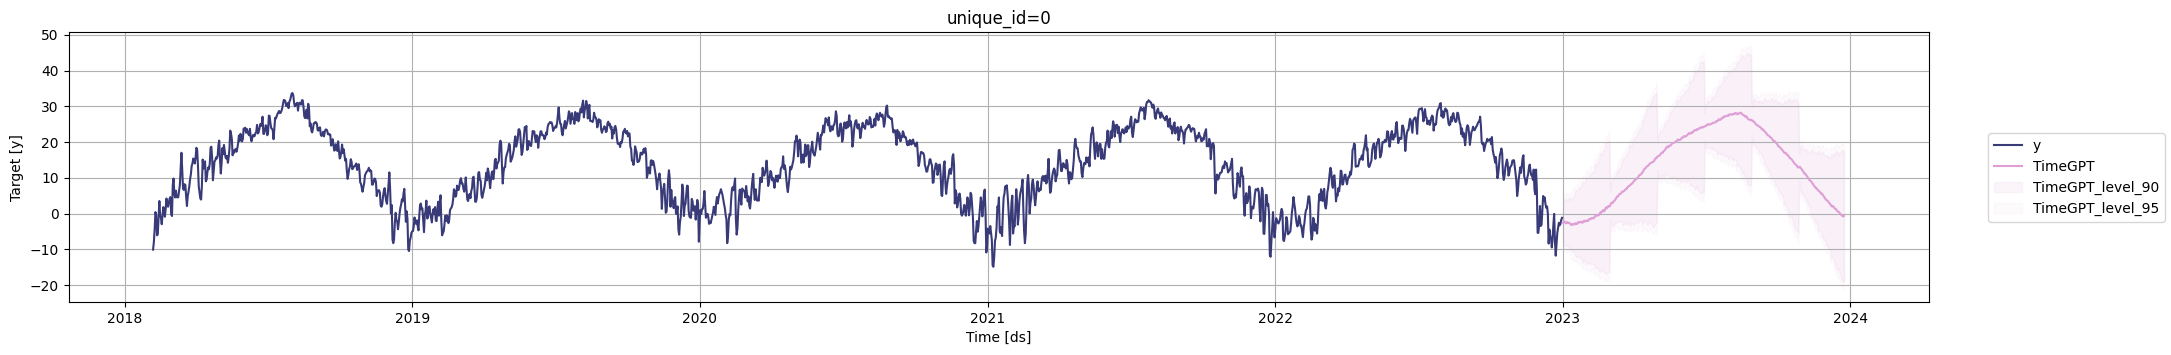

In [ ]:
timegpt.plot(train_df_mean, fcst_df, level=[90, 95], max_insample_length=358 * 5)


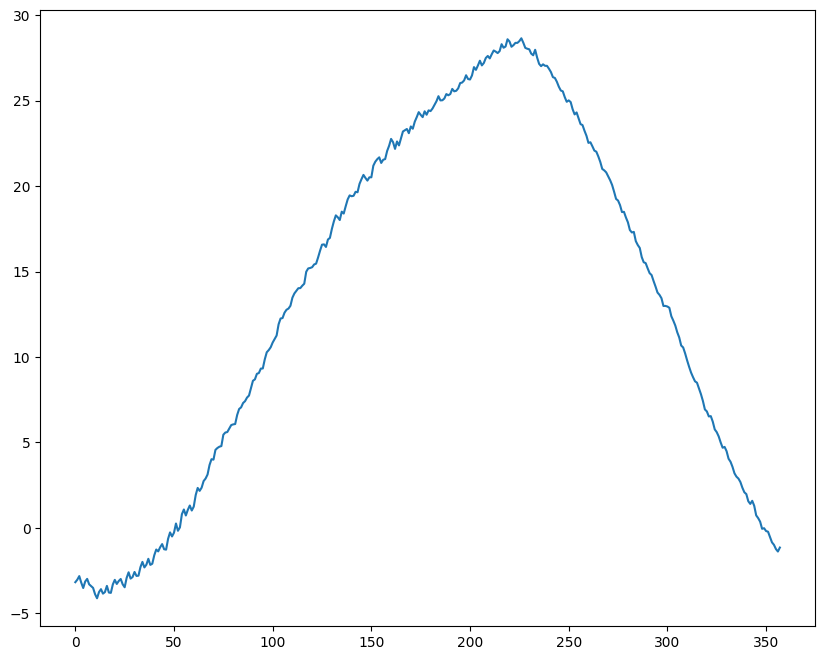

In [ ]:
plt.plot(fcst_df.TimeGPT)


In [ ]:
def mae(actual, forecast):
    return mean_absolute_error(actual, forecast)

def rmse(actual, forecast):
    return np.sqrt(mean_squared_error(actual, forecast))

def mape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    return np.mean(np.abs((actual - forecast) / actual)) * 100

def smape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    return 100/len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))


## NHits

In [ ]:
train_df_mean

ds    y  unique_id
0     1960-01-01 -1.6          0
1     1960-01-02 -1.9          0
2     1960-01-03  4.0          0
3     1960-01-04  7.5          0
4     1960-01-05 -4.6          0
...          ...  ...        ...
23006 2022-12-27 -2.6          0
23007 2022-12-28 -3.3          0
23008 2022-12-29 -2.9          0
23009 2022-12-30 -1.8          0
23010 2022-12-31 -1.2          0

[23011 rows x 3 columns]

In [ ]:
horizon = 358


In [ ]:
nhits_config = {
       "learning_rate": tune.choice([1e-4, 1e-5]),  # Consider a range of learning rates
       "max_steps": tune.choice([1000,2000]),      # More steps for more complexity
       "input_size": tune.choice([horizon//4]),    # Maintain or adjust input size
       "batch_size": tune.choice([2]),              # Experiment with batch size
       "windows_batch_size": tune.choice([256]),    # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [1, 1, 1]]),  # Smaller kernels
      #  "n_freq_downsample": tune.choice([[1, 1, 1], [4, 2, 1]]), # Less aggressive downsampling
       "activation": tune.choice(['ReLU']),         # ReLU is typically a good default
       "n_blocks":  tune.choice([[3, 3, 3]]),  # Experiment with more blocks
       "mlp_units":  tune.choice([[[256, 256], [256, 256], [256, 256]]]),  # Maintain MLP units or adjust
       "interpolation_mode": tune.choice(['linear']),  # Linear interpolation
       "random_seed": tune.randint(1, 10),
       "scaler_type": tune.choice(['robust']),  # Robust to outliers
       "val_check_steps": tune.choice([100])
    }


In [ ]:
dl_models = [AutoNHITS(h=horizon,
                    loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                    config=nhits_config,
                    num_samples=2)]

In [ ]:
# Fit and predict
nf = NeuralForecast(
    models=dl_models,
    freq='D',
    )

In [ ]:
Y_hat_df = nf.cross_validation(df=train_df_mean, val_size=358*4,
                               test_size=358*4, n_windows=None)

2024-01-01 12:30:20,721	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-01-01_12-30-20   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 2                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-01-01_12-30-20
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_train_tune_2024-01-01_12-30-20`


2024-01-01 12:31:00,587	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-01-01 12:31:00,593	WARNING tune.py:1057 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="/root/ray_results/_train_tune_2024-01-01_12-30-20", trainable=...)
2024-01-01 12:31:00,596	WARNING experiment_analysis.py:193 -- Failed to fetch metrics for 2 trial(s):
- _train_tune_5b1d8_00000: FileNotFoundError('Could not fetch metrics for _train_tune_5b1d8_00000: both result.json and progress.csv were not found at /root/ray_results/_train_tune_2024-01-01_12-30-20/_train_tune_5b1d8_00000_0_activation=ReLU,batch_size=2,input_size=89,interpolation_mode=linear,learning_rate=0.0001,max_steps=2000_2024-01-01_12-30-20')
- _train_tune_5b1d8_00001: FileNotFoundError('Could not fetch metrics for _train

RuntimeError: ignored

In [ ]:
Y_hat_df_ = Y_hat_df.reset_index(drop=True)
Y_hat_df_ = Y_hat_df_[(Y_hat_df_['unique_id']==0) & (Y_hat_df_['cutoff']=='2022-12-31')]
Y_hat_df_ = Y_hat_df_.drop(columns=['y','cutoff'])


In [ ]:
Y_df = train_df_mean

[]

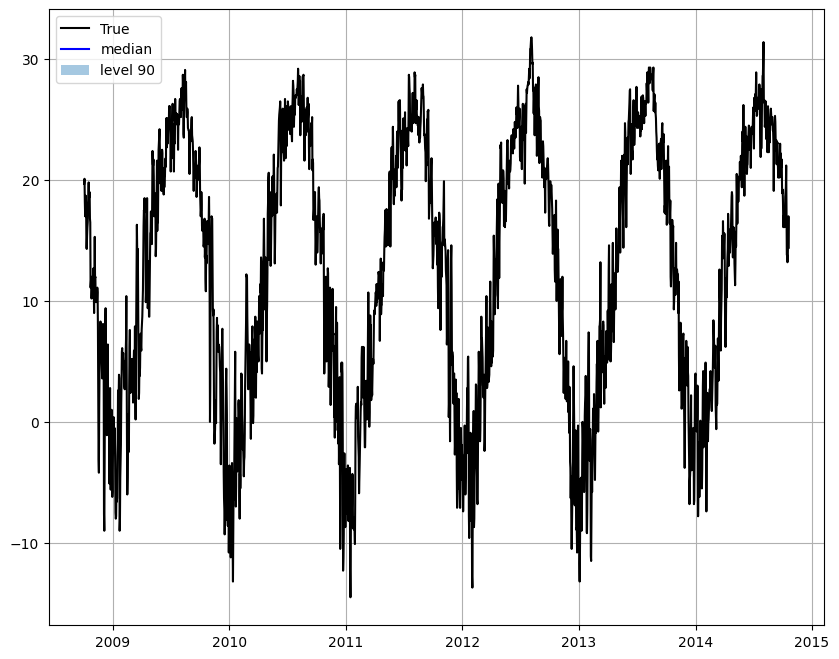

In [ ]:
plot_df = Y_df.merge(Y_hat_df_, on=['unique_id','ds'], how='outer').tail(368*10+50+368*4).head(368*2+368*4)

plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['AutoNHITS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'],
                    y1=plot_df['AutoNHITS-lo-90'], y2=plot_df['AutoNHITS-hi-90'],
                    alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

In [ ]:
nf.fit(df=train_df_mean)

2024-01-01 12:28:55,755	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-01-01_12-28-55   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 2                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-01-01_12-28-55
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_train_tune_2024-01-01_12-28-55`


ValueError: ignored

In [ ]:
pred_dl_df = nf.predict()
pred_dl_df = pred_dl_df.reset_index()
pred_dl_df.head()


Predicting: |          | 0/? [00:00<?, ?it/s]

unique_id         ds  AutoNHITS  AutoNHITS-median  AutoNHITS-lo-90  \
0          0 2023-01-01  -0.846022         -0.764167        -7.002528   
1          0 2023-01-02  -0.237865          0.159645        -9.680535   
2          0 2023-01-03  -0.044975         -0.196467       -10.831665   
3          0 2023-01-04   0.036374          0.407560       -11.040339   
4          0 2023-01-05  -0.183652          0.032472       -11.110640   

   AutoNHITS-lo-80  AutoNHITS-hi-80  AutoNHITS-hi-90  
0        -5.642679         3.996934         5.329844  
1        -7.955857         6.956870         8.722201  
2        -8.058355         8.313197        10.956605  
3        -8.938582         8.664213        11.241295  
4        -8.539296         8.240542        10.192537

In [ ]:
nf.save(path='.',
        model_index=None,
        overwrite=True,
        save_dataset=True)

## TimesNet

In [ ]:
del model
del nf

NameError: ignored

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
h = 358

In [ ]:
model = TimesNet(h=h,
                 input_size=(h//4),
                 hidden_size = h,
                 conv_hidden_size = h,
                 #loss=MAE(),
                 #loss=MQLoss(quantiles=[0.2, 0.5, 0.8]),
                 loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                 scaler_type='robust',
                 learning_rate=1e-4,
                 max_steps=20,
                 val_check_steps=50,
                 batch_size=2,
                 early_stop_patience_steps=2)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
nf = NeuralForecast(
    models=[model],
    freq='D'
)

In [ ]:
Y_hat_df = nf.cross_validation(df=train_df_mean, val_size=358,
                               test_size=358, n_windows=None)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
Y_hat_df_ = Y_hat_df.reset_index(drop=True)
Y_hat_df_ = Y_hat_df_[(Y_hat_df_['unique_id']==0) & (Y_hat_df_['cutoff']=='2022-12-31')]
Y_hat_df_ = Y_hat_df_.drop(columns=['y','cutoff'])


In [ ]:
Y_df = train_df_mean


In [ ]:
plot_df = Y_df.merge(Y_hat_df_, on=['unique_id','ds'], how='outer').tail(368*10+50+368*4).head(368*2+368*4)

plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['AutoNHITS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'],
                    y1=plot_df['AutoNHITS-lo-90'], y2=plot_df['AutoNHITS-hi-90'],
                    alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

In [ ]:
nf.fit(df=train_df_mean, val_size=1)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
pred_dl_df = nf.predict()
pred_dl_df = pred_dl_df.reset_index()
pred_dl_df.head()


In [ ]:
nf.save(path='.',
        model_index=None,
        overwrite=True,
        save_dataset=True)

# Manual Inference

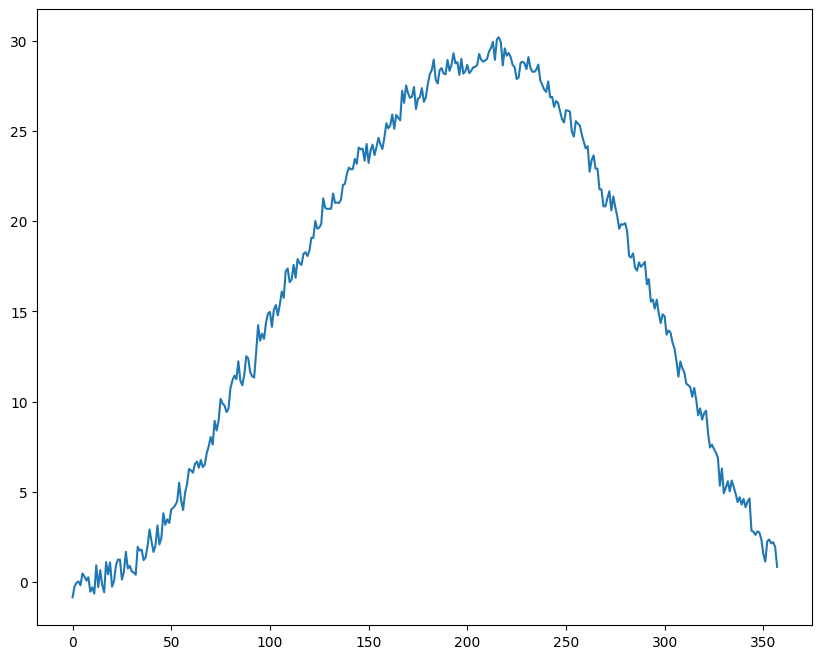

In [ ]:
plt.plot(pred_dl_df['AutoNHITS'])

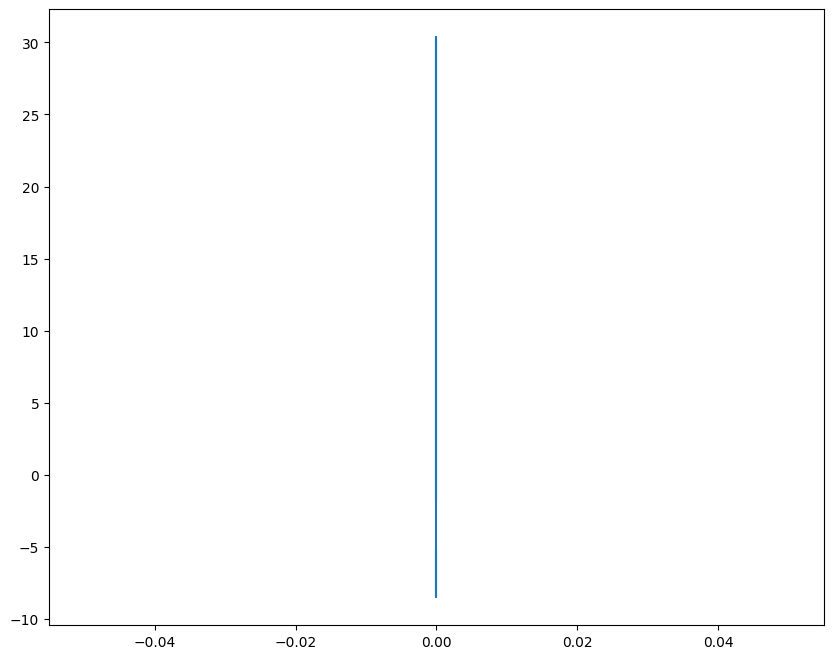

In [ ]:
plt.plot(st_pred.MSTL)

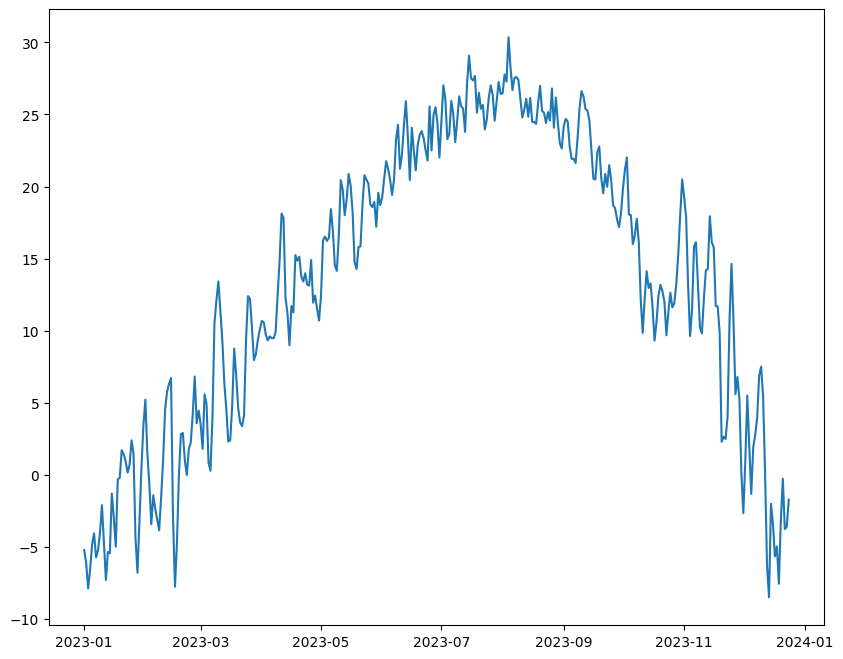

In [ ]:
plt.plot(st_pred.set_index('ds'))

In [ ]:
st_pred_ = st_pred.set_index('ds')

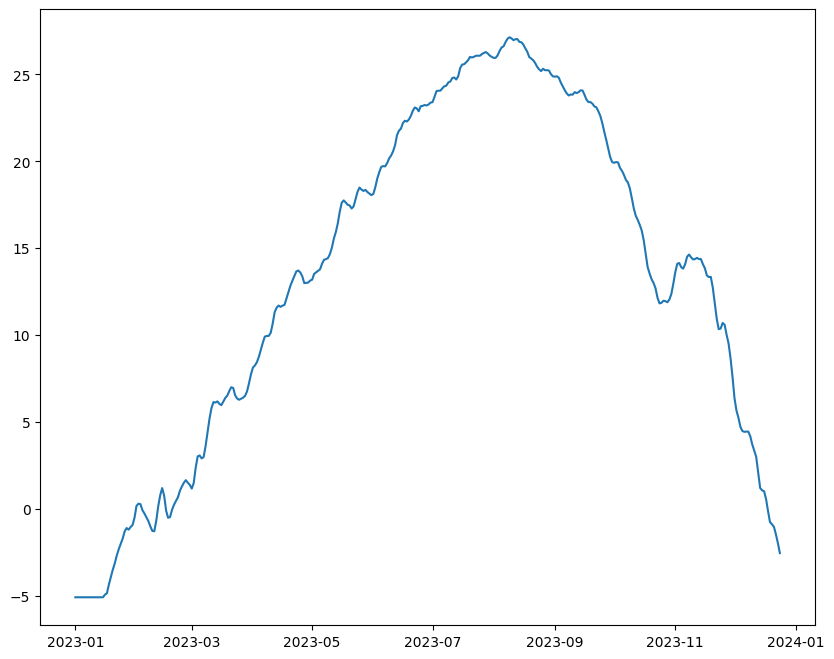

In [ ]:
plt.plot(st_pred_.rolling(window=15).mean().fillna(method='bfill'))

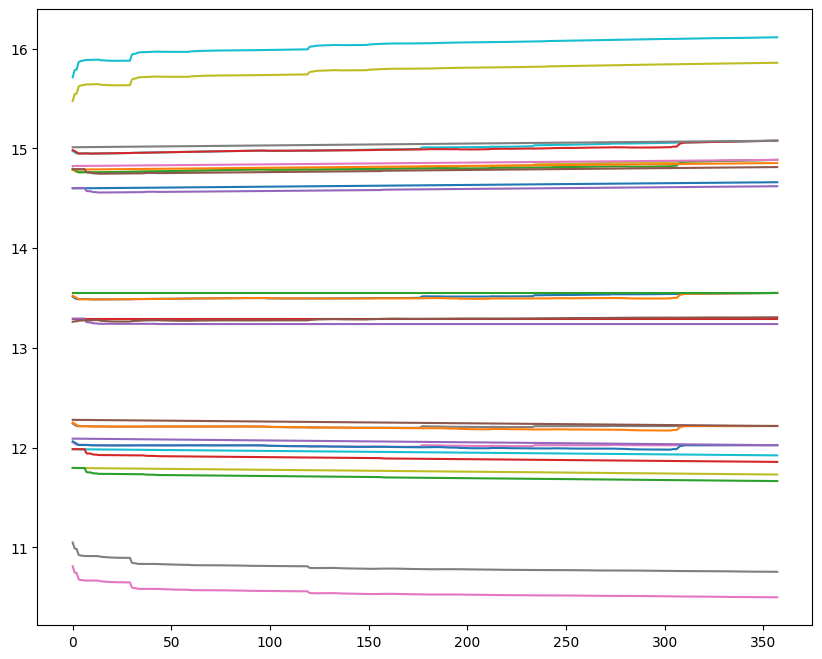

In [ ]:
plt.plot(predictions_trend.drop(['unique_id', 'ds'],axis=1))


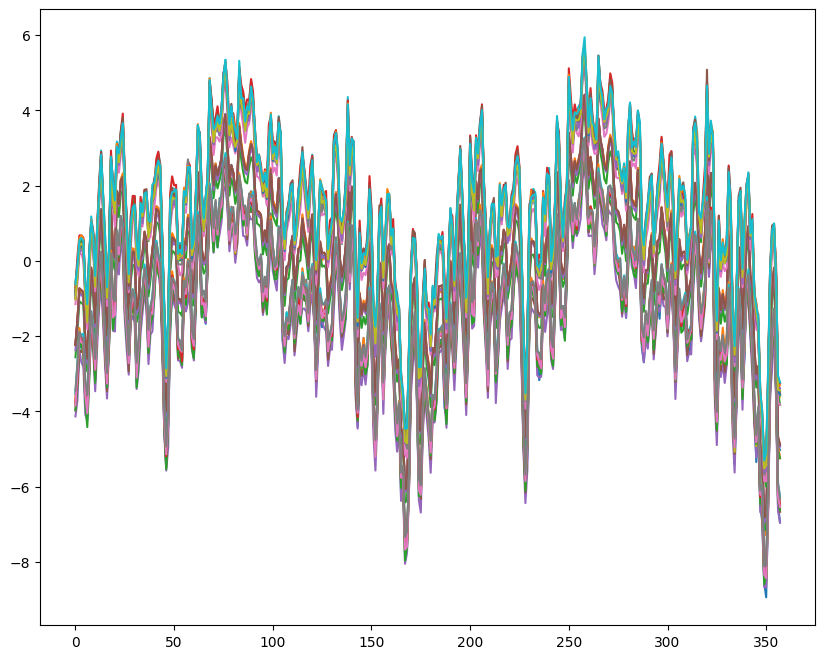

In [ ]:
plt.plot(predictions_90s.drop(['unique_id', 'ds'],axis=1))


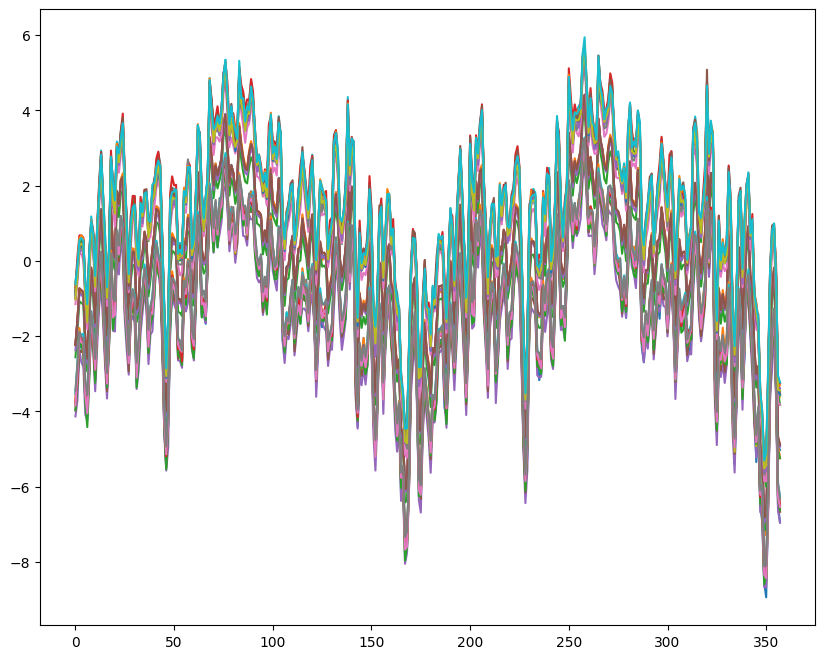

In [ ]:
plt.plot(predictions_182s.drop(['unique_id', 'ds'],axis=1))

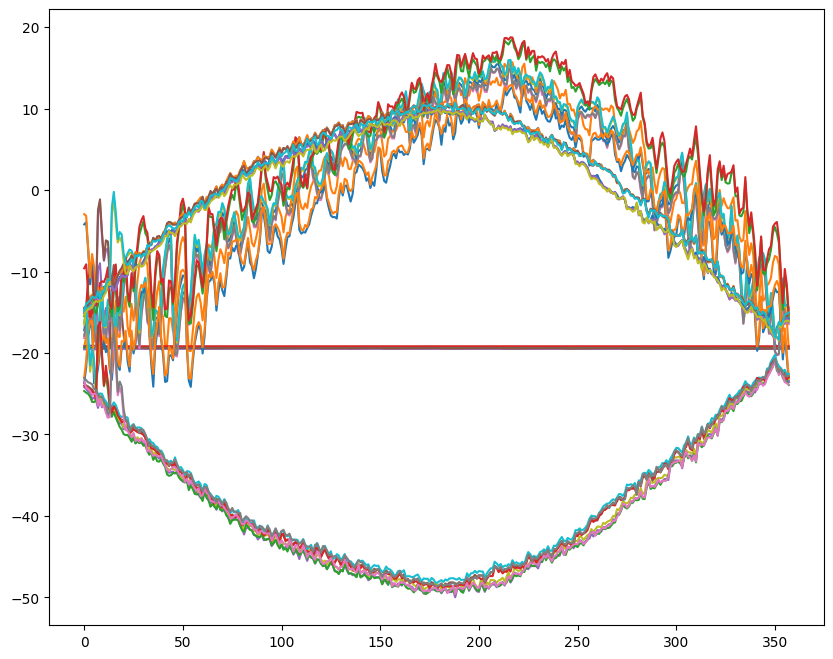

In [ ]:
plt.plot(predictions_365s.drop(['unique_id', 'ds'],axis=1))


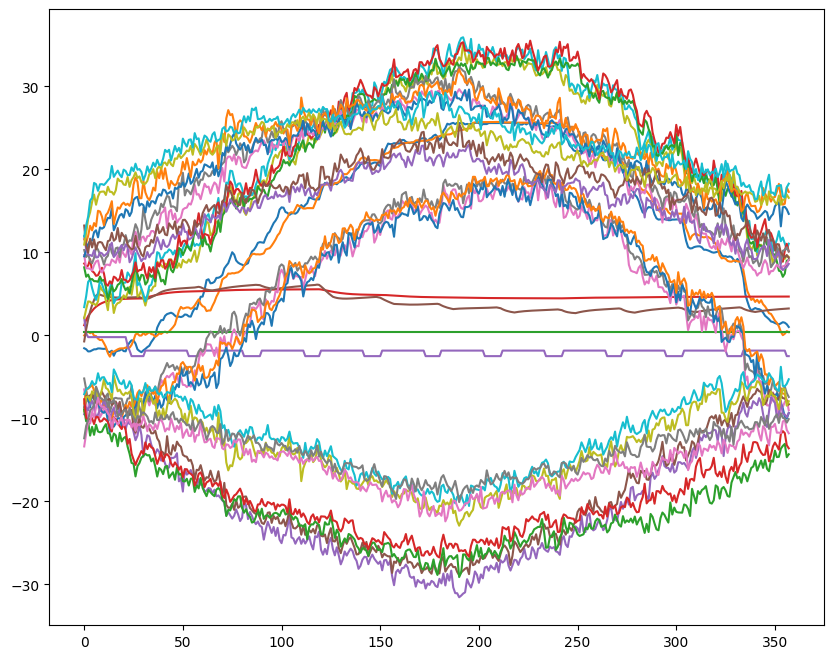

In [ ]:
plt.plot(predictions_4380s.drop(['unique_id', 'ds'],axis=1))


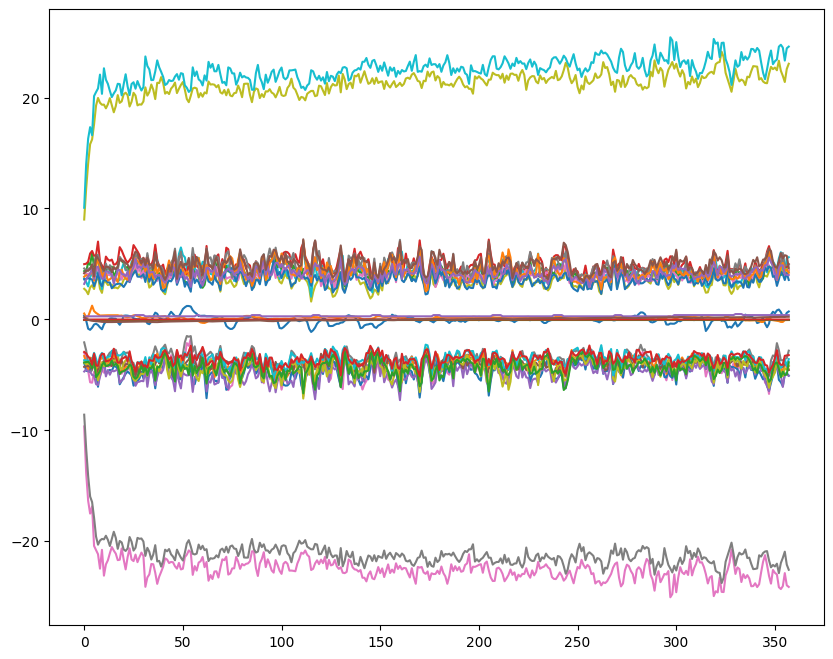

In [ ]:
plt.plot(predictions_resid.drop(['unique_id', 'ds'],axis=1))


In [ ]:
res.seasonal.std()

seasonal_90      0.414924
seasonal_182     0.879371
seasonal_365     9.837634
seasonal_4380    2.491391
dtype: float64

In [ ]:
train_df_mean.std()

ds           6642 days 20:20:54.945061504
y                               10.489515
unique_id                             0.0
dtype: object

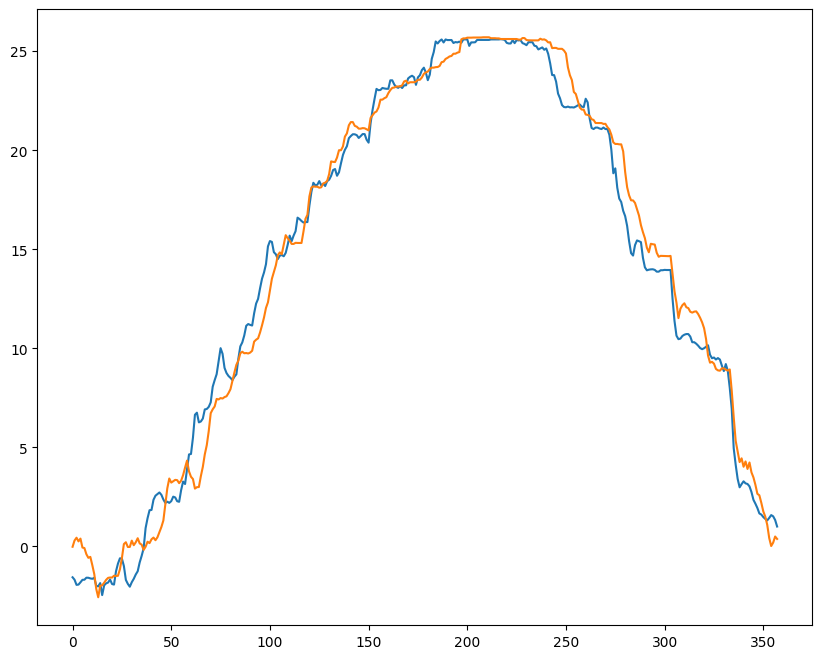

In [ ]:
plt.plot(predictions_4380s.lgb_1)
plt.plot(predictions_4380s.lgb_2)

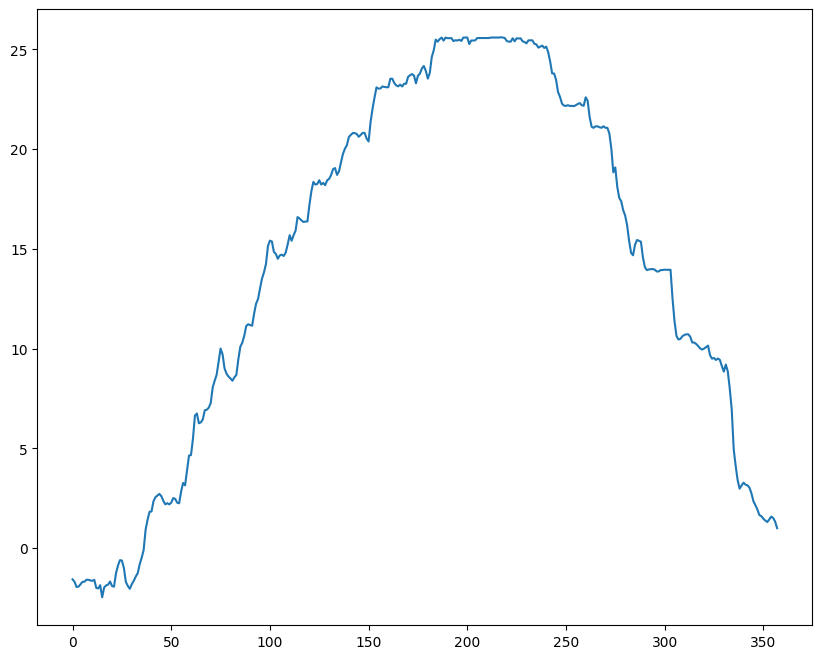

In [ ]:
# plt.plot(predictions_trend.naive  + predictions_365s.lgb_2 + predictions_4380s.lgb_1 + predictions_resid.lgb_1)
# plt.plot(predictions_4380s.lgb_1+predictions_resid.lgb_1)
# plt.plot(predictions_365s.lgb_1+predictions_trend.lgb_1)
plt.plot(predictions_4380s.lgb_1)
# plt.plot(predictions_resid.lgb_1)


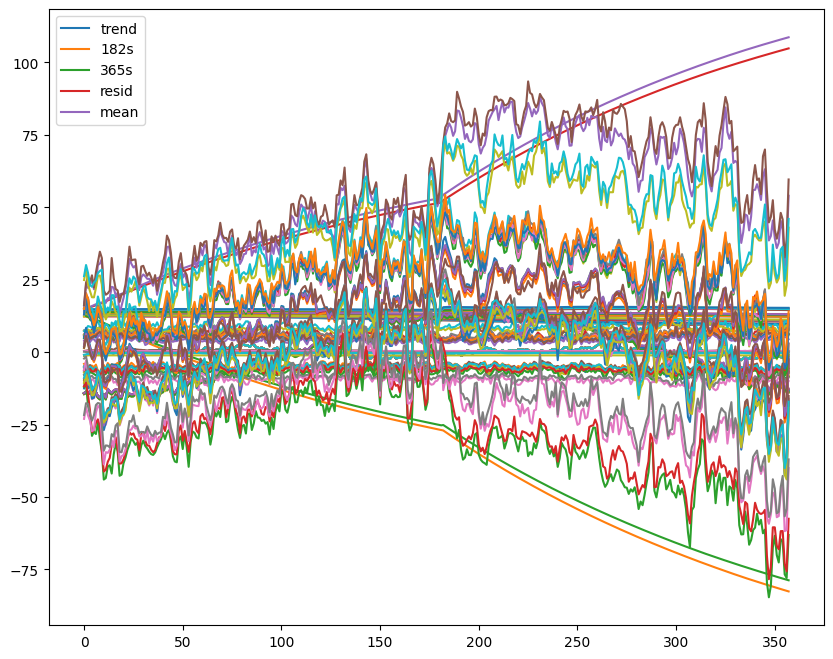

In [ ]:
plt.plot(predictions_trend.drop(['unique_id', 'ds'],axis=1))
plt.plot(predictions_182s.drop(['unique_id', 'ds'],axis=1))
plt.plot(predictions_365s.drop(['unique_id', 'ds'],axis=1))
plt.plot(predictions_resid.drop(['unique_id', 'ds'],axis=1))
plt.plot(predictions_mean.drop(['unique_id', 'ds'],axis=1))
plt.legend(['trend', '182s', '365s', 'resid', 'mean'])

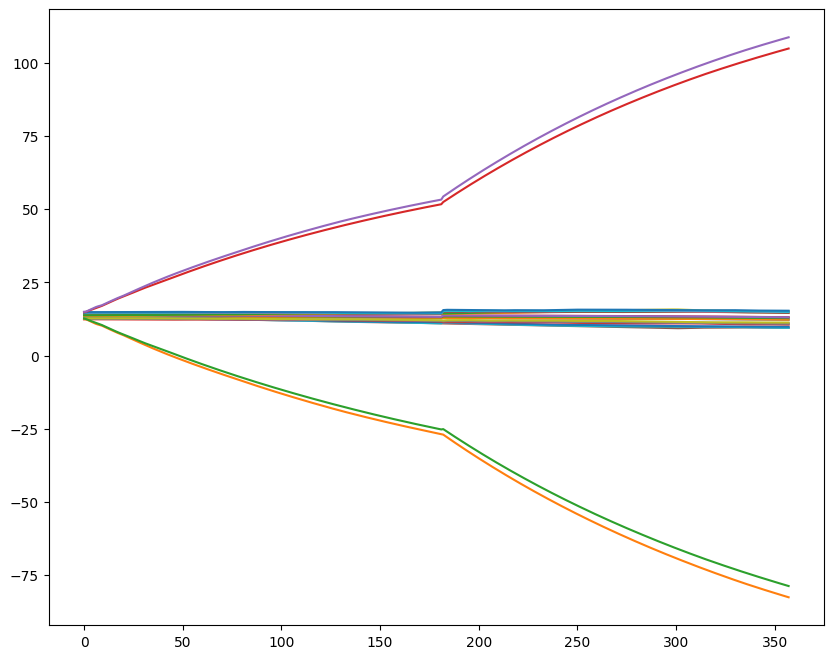

In [ ]:
plt.plot(predictions_trend.drop(['unique_id', 'ds'],axis=1))

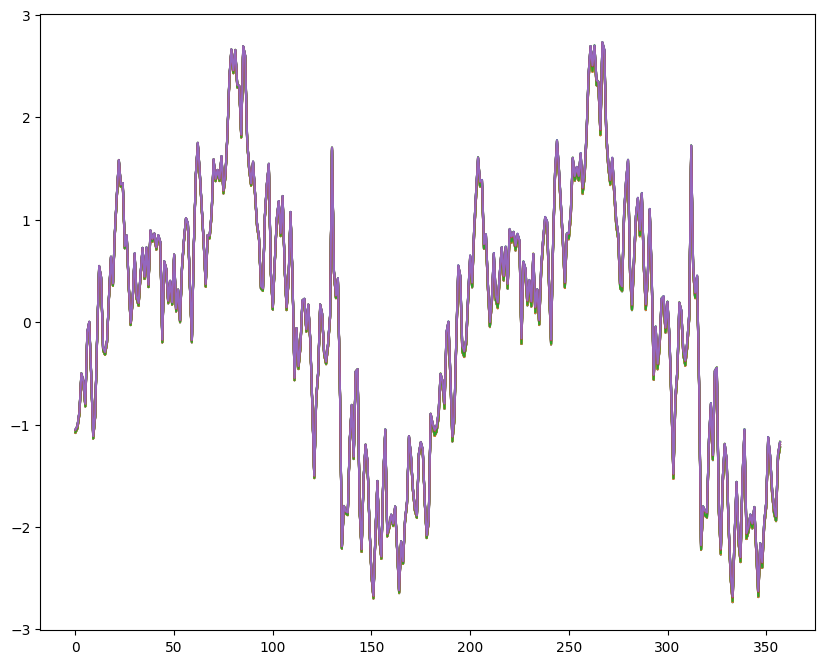

In [ ]:
plt.plot(predictions_182s.drop(['unique_id', 'ds'],axis=1))

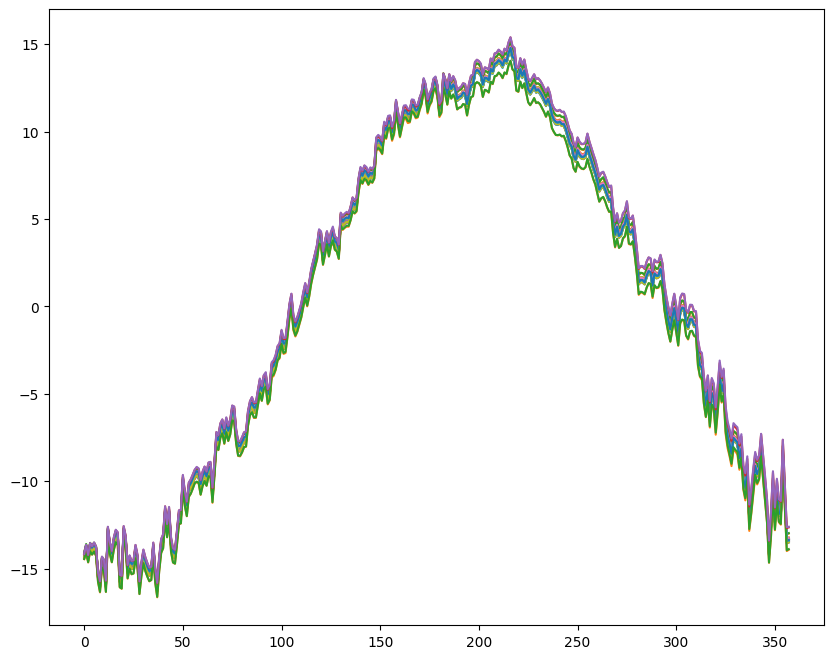

In [ ]:
plt.plot(predictions_365s.drop(['unique_id', 'ds'],axis=1))

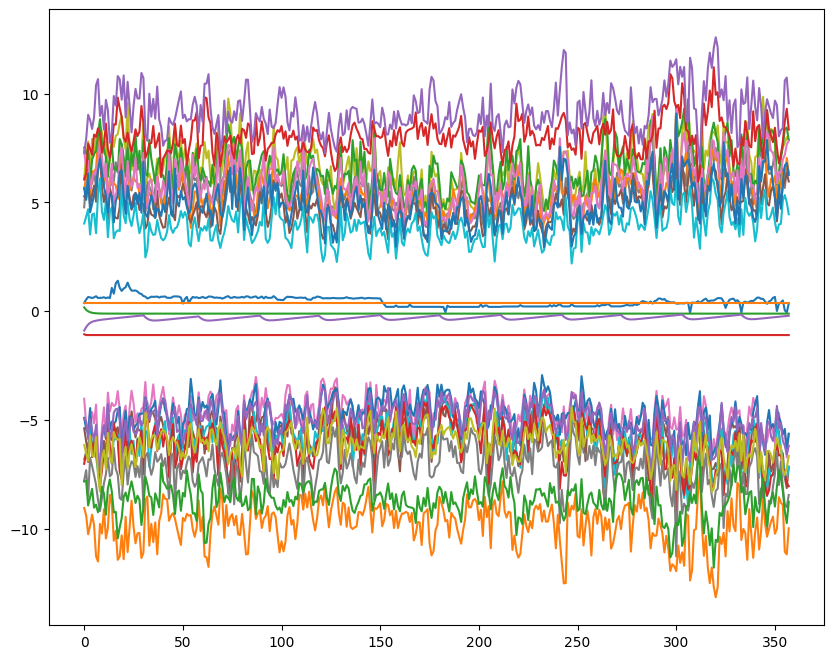

In [ ]:
plt.plot(predictions_resid.drop(['unique_id', 'ds'],axis=1))

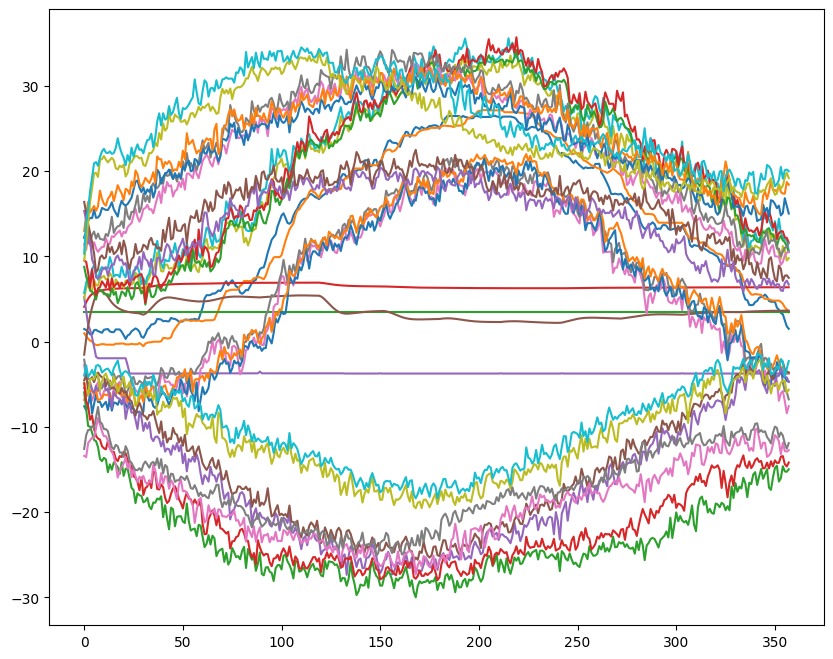

In [ ]:
plt.plot(predictions_mean.drop(['unique_id', 'ds'],axis=1))

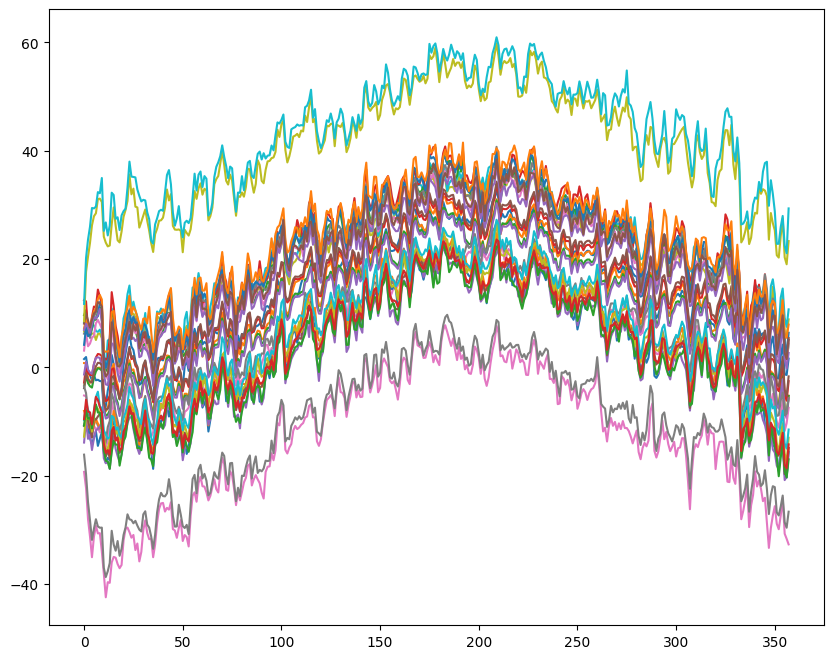

In [ ]:
plt.plot(predictions_mean_diff.drop(['unique_id', 'ds'],axis=1))

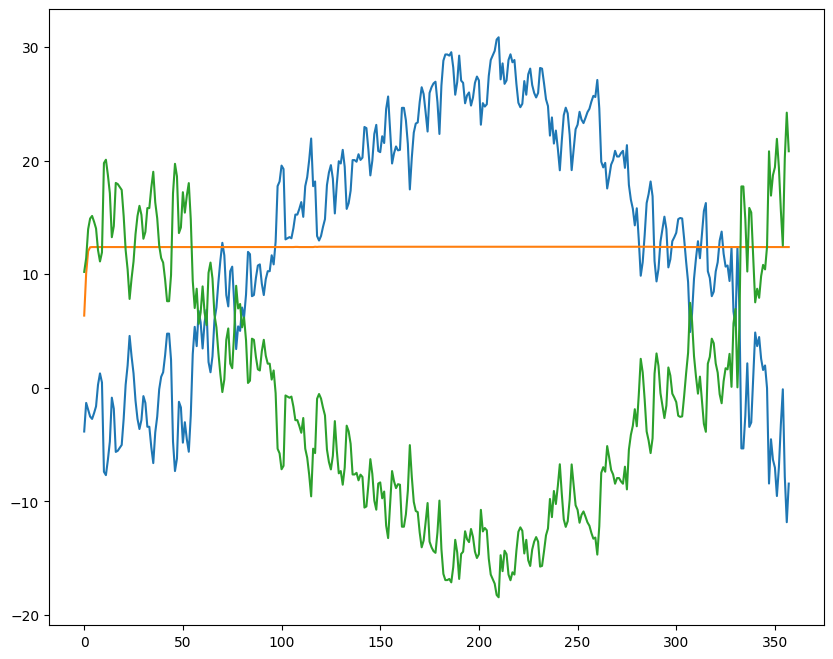

In [ ]:
plt.plot(predictions_mean_diff.lgb_1)
plt.plot(predictions_mean.lgb_1)
plt.plot(
    predictions_mean.lgb_1-
    predictions_mean_diff.lgb_1
)

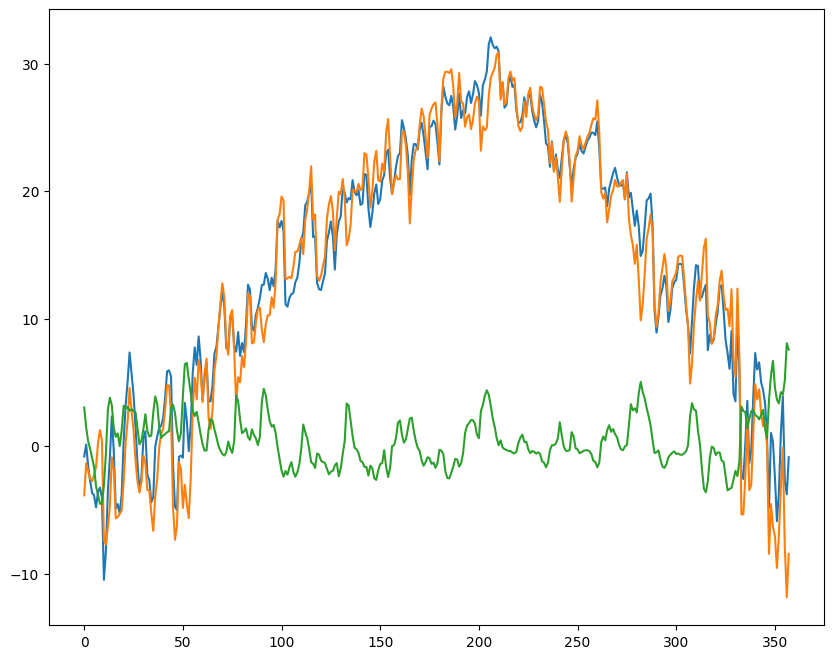

In [ ]:
plt.plot(predictions_mean_diff.lgb_1)
plt.plot(predictions_mean_diff.lgb_2)
plt.plot(
    predictions_mean_diff.lgb_1-
    predictions_mean_diff.lgb_2
)

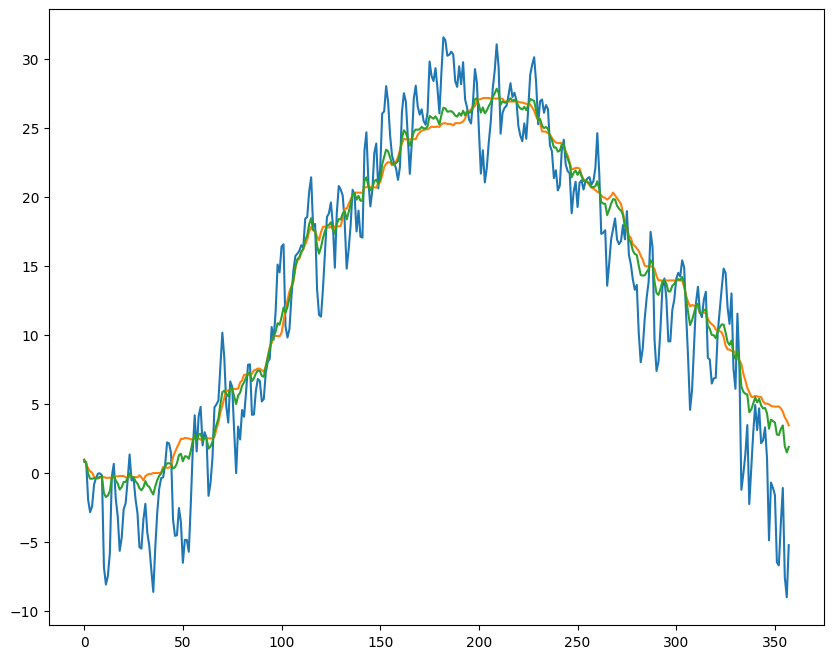

In [ ]:
plt.plot(predictions_mean_diff.lgb_2)
plt.plot(predictions_mean.lgb_2)
plt.plot(
    0.82*predictions_mean.lgb_2+
    0.18*predictions_mean_diff.lgb_2
)

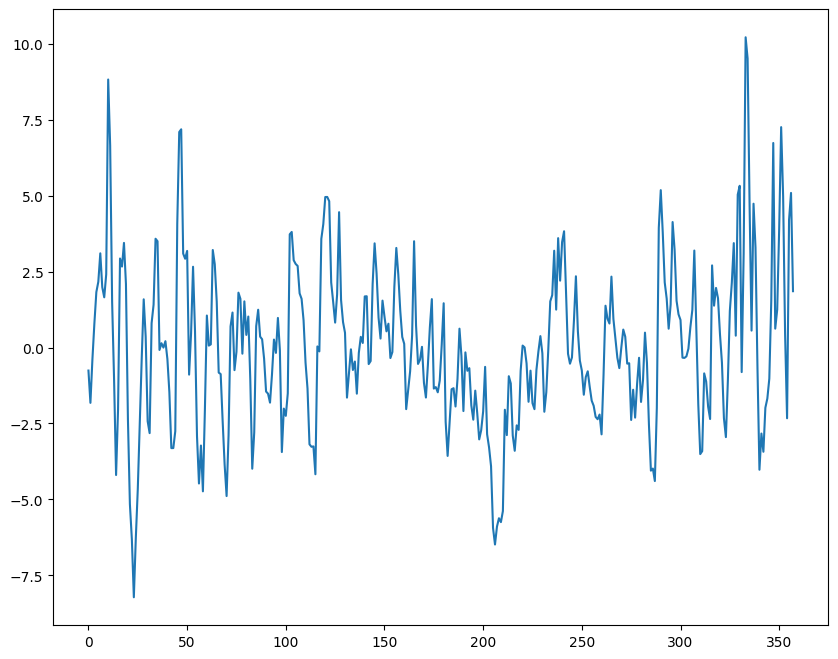

In [ ]:
plt.plot(predictions_mean.lgb_1-predictions_mean_diff.lgb_1)

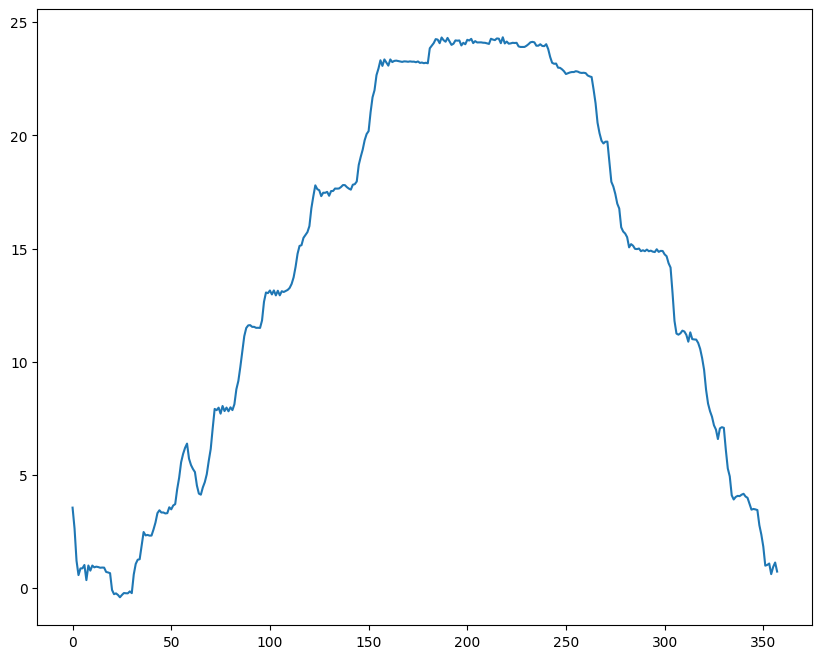

In [ ]:
plt.plot(predictions_mean.se)


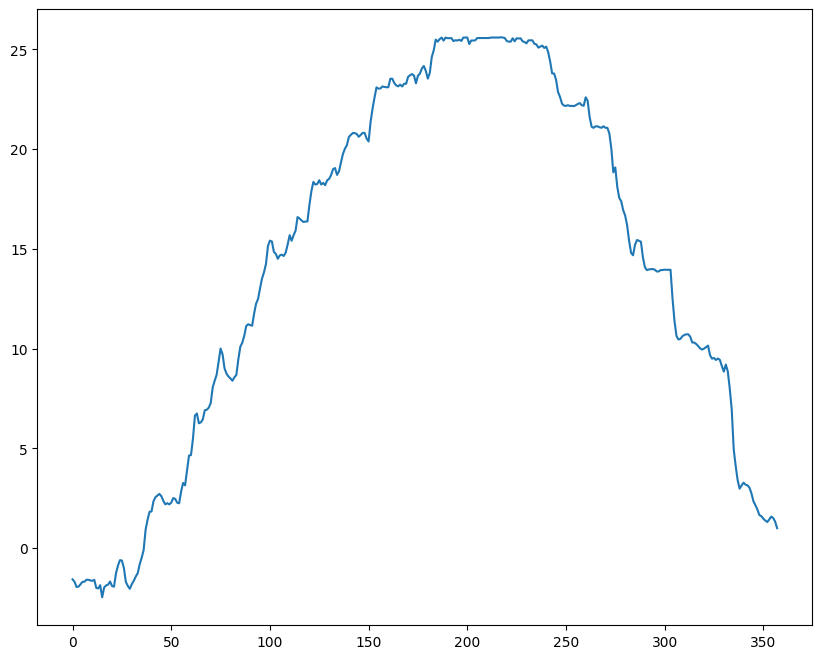

In [ ]:
plt.plot(predictions_mean.lgb_1)


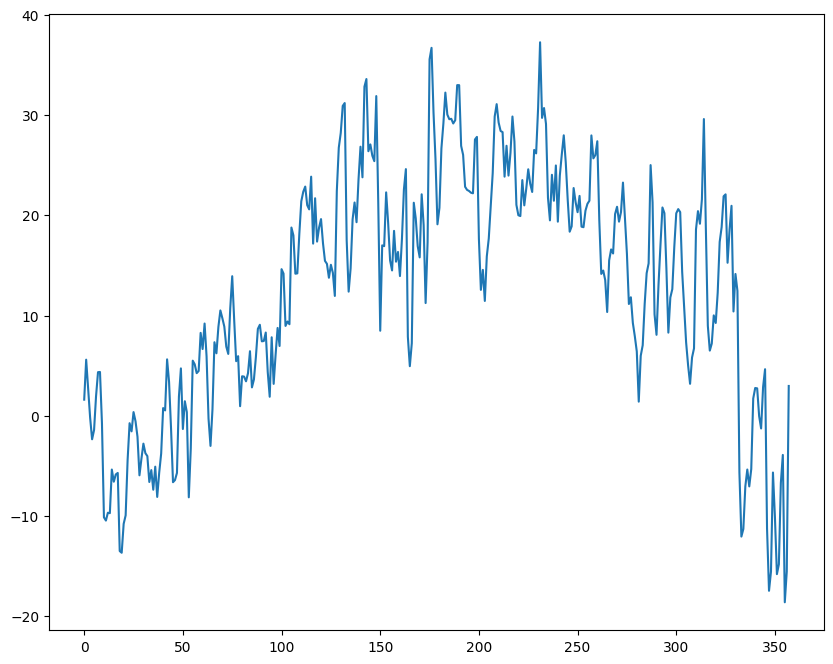

In [ ]:
plt.plot(predictions_mean.se)

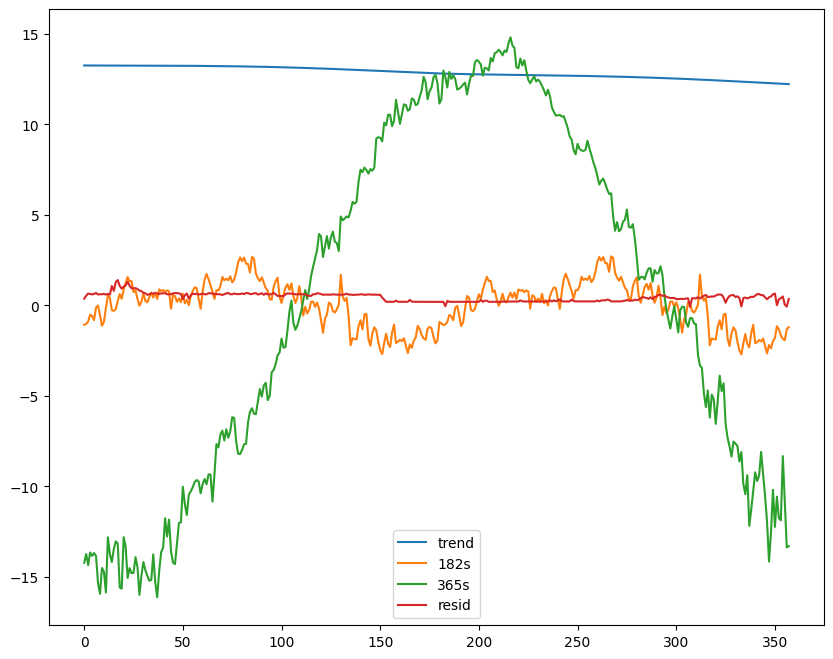

In [ ]:
plt.plot(predictions_trend.naive)
plt.plot(predictions_182s.lasso)
plt.plot(predictions_365s.lgb_1)
plt.plot(predictions_resid.lgb_1)

plt.legend(['trend', '182s', '365s', 'resid'])

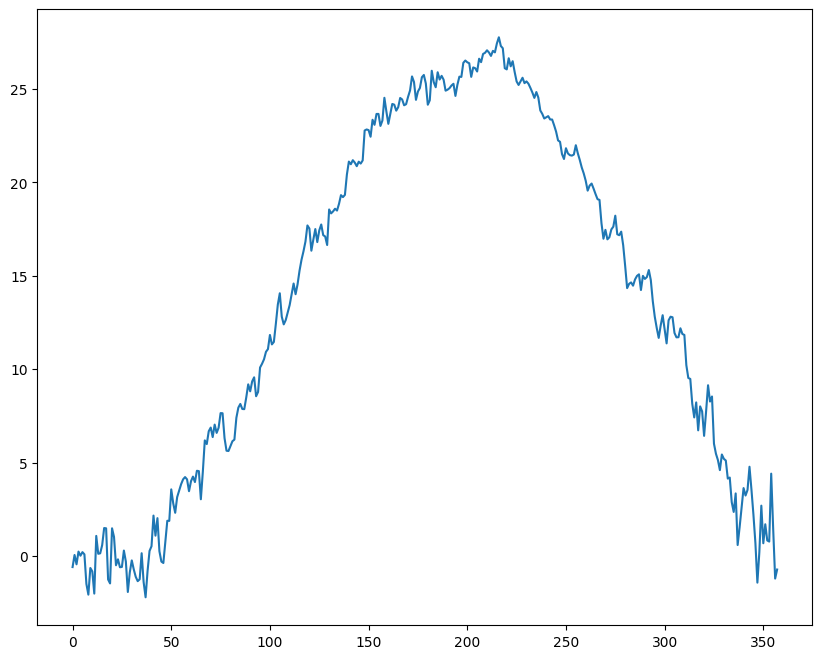

In [ ]:
plt.plot(predictions_trend.naive + predictions_365s.lgb_1 + predictions_resid.lgb_1)

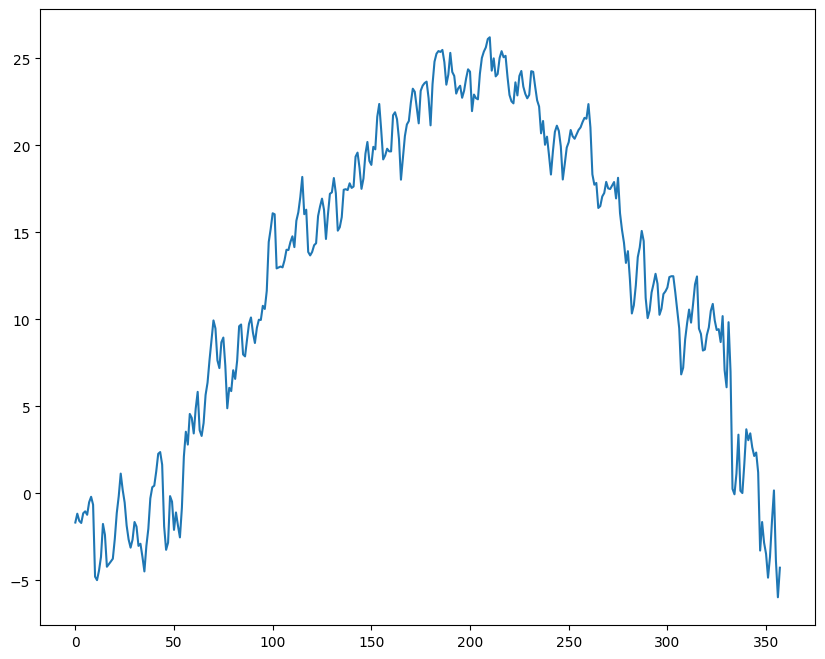

In [ ]:
plt.plot(((predictions_mean_diff['lasso']+predictions_mean['lgb_1']))/2)

# Submit result

In [ ]:
pred = pred_dl_df['AutoNHITS']

In [ ]:
pred = pred.values

In [ ]:
pred = ((predictions_min_diff['lasso'])+(predictions_mean_diff['lasso']+predictions_mean['lgb_1'])+(predictions_max_diff['lasso']+predictions_max['lgb_1']))/5

In [ ]:
pred_2 = ((predictions_min['lgb_1'])+ (predictions_mean['lgb_1']))/2

In [ ]:
pred_3 = ((predictions_min['lgb_1'])+ (predictions_mean['lgb_1']) + predictions_max['lgb_1'])/3

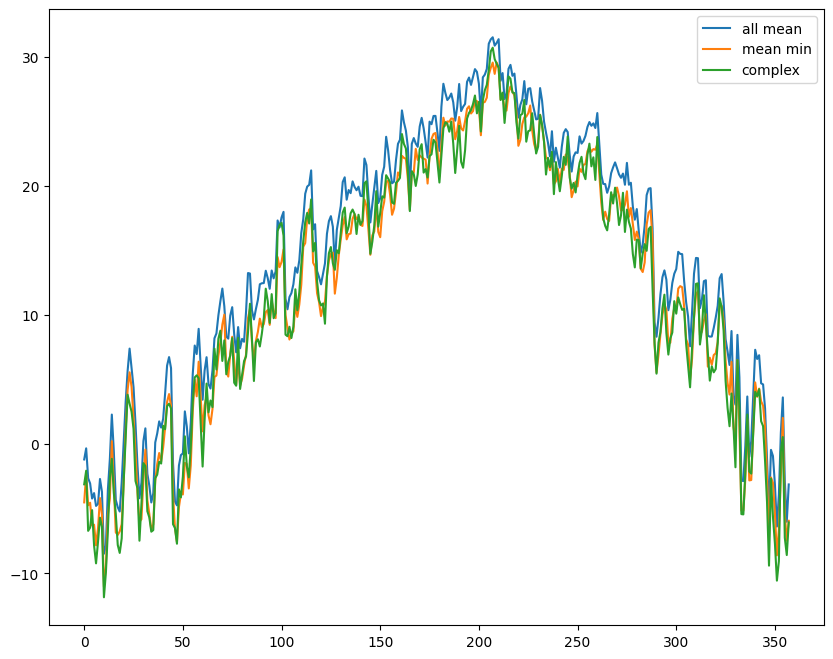

In [ ]:
plt.plot(((predictions_min['lgb_1'])+ (predictions_mean['lgb_1']) + predictions_max['lgb_1'])/3)
plt.plot(((predictions_min['lgb_1'])+ (predictions_mean['lgb_1']))/2)
plt.plot(pred)
plt.legend(['all mean', 'mean min', 'complex'])

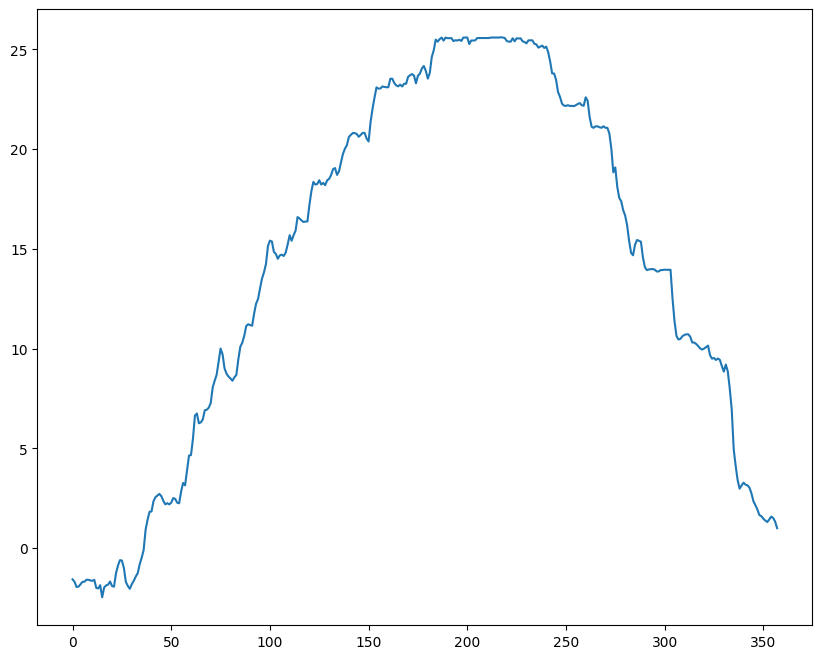

In [ ]:
plt.plot(pred)


In [ ]:
submission_df['일시'] = pd.to_datetime(submission_df['일시'])

# 예측할 기간 설정
start_date = submission_df['일시'].min()
end_date = submission_df['일시'].max()

In [ ]:
end_date - start_date

Timedelta('357 days 00:00:00')

In [ ]:
end_date

Timestamp('2023-12-24 00:00:00')

In [ ]:
# 예측 결과 추출 및 확인
submission_df['평균기온'] = pred
display(submission_df.head())

# 예측 결과 저장
submission_df.to_csv('./baseline_submit_NHits_6.csv', index=False)

일시      평균기온
0  2023-01-01 -0.846022
1  2023-01-02 -0.237865
2  2023-01-03 -0.044975
3  2023-01-04  0.036374
4  2023-01-05 -0.183652

In [ ]:
display(submission_df.tail(10))

일시      평균기온
348  2023-12-15  3.101262
349  2023-12-16  2.749992
350  2023-12-17  2.410603
351  2023-12-18  2.110892
352  2023-12-19  1.892528
353  2023-12-20  2.144833
354  2023-12-21  2.197374
355  2023-12-22  1.627940
356  2023-12-23  1.427094
357  2023-12-24  1.215291

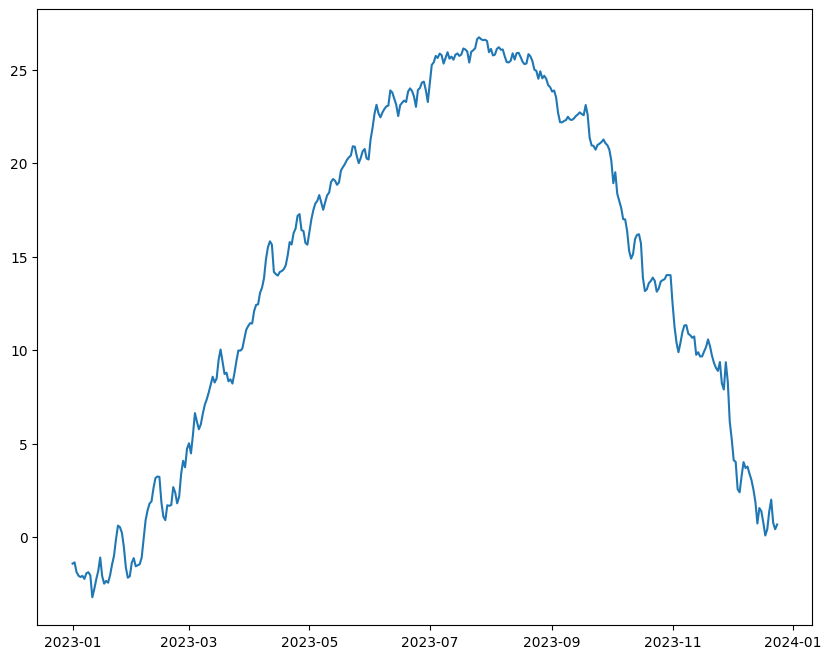

In [ ]:
submission_df_ = submission_df.copy()
submission_df_['일시'] = pd.to_datetime(submission_df_['일시'])
submission_df_ = submission_df_.set_index('일시')
submission_df_['평균기온']
plt.plot(submission_df_['평균기온'])


In [ ]:
plt.plot(submission_df_['평균기온'])


In [ ]:
train_df

최고기온  최저기온   일교차  평균습도  평균풍속  일조합        일조율         ds    y  unique_id
0       2.2  -5.2   7.4  68.3   1.7  6.7  48.653526 1960-01-01 -1.6          0
1       1.2  -5.6   6.8  87.7   1.3  0.0  48.653526 1960-01-02 -1.9          0
2       8.7  -2.1  10.8  81.3   3.0  0.0  48.653526 1960-01-03  4.0          0
3      10.8   1.2   9.6  79.7   4.4  2.6  48.653526 1960-01-04  7.5          0
4       1.3  -8.2   9.5  44.0   5.1  8.2  48.653526 1960-01-05 -4.6          0
...     ...   ...   ...   ...   ...  ...        ...        ...  ...        ...
23006   3.3  -7.3  10.6  69.8   1.8  8.8  91.700000 2022-12-27 -2.6          0
23007   0.1  -6.0   6.1  58.1   2.5  8.7  90.600000 2022-12-28 -3.3          0
23008   2.1  -7.8   9.9  56.3   1.7  9.0  93.800000 2022-12-29 -2.9          0
23009   2.3  -4.4   6.7  65.6   1.9  7.9  82.300000 2022-12-30 -1.8          0
23010   2.1  -5.1   7.2  65.5   1.4  1.1  11.500000 2022-12-31 -1.2          0

[23011 rows x 10 columns]

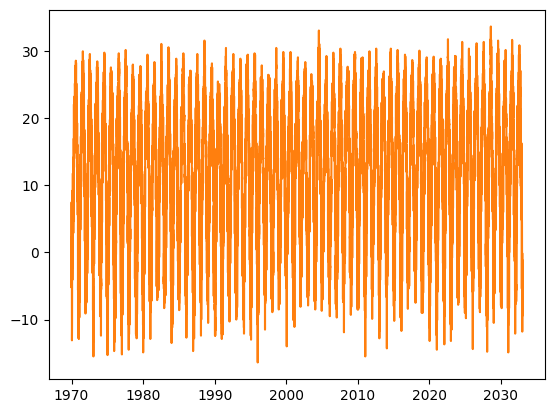

In [ ]:
plt.plot(submission_df_['평균기온'])
plt.plot(train_df.y)

In [ ]:
submission_df_.isna().sum()

평균기온    0
dtype: int64

In [ ]:
train_df

최고기온  최저기온   일교차  평균습도  평균풍속  일조합        일조율         ds    y  unique_id
0       2.2  -5.2   7.4  68.3   1.7  6.7  48.653526 1960-01-01 -1.6          0
1       1.2  -5.6   6.8  87.7   1.3  0.0  48.653526 1960-01-02 -1.9          0
2       8.7  -2.1  10.8  81.3   3.0  0.0  48.653526 1960-01-03  4.0          0
3      10.8   1.2   9.6  79.7   4.4  2.6  48.653526 1960-01-04  7.5          0
4       1.3  -8.2   9.5  44.0   5.1  8.2  48.653526 1960-01-05 -4.6          0
...     ...   ...   ...   ...   ...  ...        ...        ...  ...        ...
23006   3.3  -7.3  10.6  69.8   1.8  8.8  91.700000 2022-12-27 -2.6          0
23007   0.1  -6.0   6.1  58.1   2.5  8.7  90.600000 2022-12-28 -3.3          0
23008   2.1  -7.8   9.9  56.3   1.7  9.0  93.800000 2022-12-29 -2.9          0
23009   2.3  -4.4   6.7  65.6   1.9  7.9  82.300000 2022-12-30 -1.8          0
23010   2.1  -5.1   7.2  65.5   1.4  1.1  11.500000 2022-12-31 -1.2          0

[23011 rows x 10 columns]